In [ ]:
!pip install -q ultralytics scikit-learn pyyaml albumentations==1.3.1 pycocotools
!pip install -q timm==0.4.12 segmentation-models-pytorch==0.2.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 9.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os

if os.path.exists('/content/drive'):
    try:
        drive.flush_and_unmount()
        print("Drive unmounted successfully.")
    except ValueError:
        print("Drive was not mounted, or unmount failed. Proceeding.")
    except Exception as e:
        print(f"An unexpected error occurred during unmount: {e}")

drive.mount('/content/drive', force_remount=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import os, json, shutil, random, math, warnings
from pathlib import Path
from collections import defaultdict, Counter
import numpy as np
import cv2
from tqdm import tqdm
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim

import albumentations as A
import timm
from pycocotools import mask as maskUtils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from ultralytics import YOLO

warnings.filterwarnings("ignore")

In [ ]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DATA_ROOT = "/content/drive/MyDrive/data"
IMAGES_DIR = os.path.join(DATA_ROOT, "images")
COCO_ANN_PATH = "/content/drive/MyDrive/SWIN FIXED/annotations.json"

WORK_DIR = "/content/drive/MyDrive/caries_project_all_in_one"
os.makedirs(WORK_DIR, exist_ok=True)


SPLIT_PATH = os.path.join(WORK_DIR, "split_manifest.json")


YOLO_DIR = os.path.join(WORK_DIR, "yolo")
YOLO_IMGS = {k: os.path.join(YOLO_DIR, f"images/{k}") for k in ["train","val","test"]}
YOLO_LBLS = {k: os.path.join(YOLO_DIR, f"labels/{k}") for k in ["train","val","test"]}
YOLO_DATA_YAML = os.path.join(YOLO_DIR, "data.yaml")
YOLO_MODEL_INIT = "yolov8m.pt"   # change if you prefer 'n','s','l','x'
YOLO_RUNS_DIR = os.path.join(WORK_DIR, "yolo_runs")
os.makedirs(YOLO_RUNS_DIR, exist_ok=True)


SWIN_DIR = os.path.join(WORK_DIR, "swin")
CROPPED_IMG_DIR = os.path.join(SWIN_DIR, "cropped_images")
CROPPED_ANN_PATH = os.path.join(SWIN_DIR, "annotations_cropped.json")
SWIN_OUT_DIR = os.path.join(SWIN_DIR, "runs")
os.makedirs(CROPPED_IMG_DIR, exist_ok=True)
os.makedirs(SWIN_OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:

CARIES_CATEGORIES = ["RA", "RB", "RC"]
CLASS_MAPPING_COARSE = {
    "ICCMS_RA2": "RA",
    "ICCMS_RA3": "RA",
    "ICCMS_RB4": "RB",
    "ICCMS_RC5": "RC",
    "ICCMS_RC6": "RC",
}

MERGED_CLASS_NAMES = ["ICCMS_RA2", "ICCMS_RA3", "ICCMS_RC5", "ICCMS_RC6"]
CLASS_TO_IDX_FINE = {name: idx for idx, name in enumerate(MERGED_CLASS_NAMES)}
NUM_CLASSES_FINE = len(MERGED_CLASS_NAMES)

ORIGINAL_TO_MERGED_FINE = {
    "ICCMS_RA1": "ICCMS_RA2",
    "ICCMS_RA2": "ICCMS_RA2",
    "ICCMS_RA3": "ICCMS_RA3",
    "ICCMS_RB4": "ICCMS_RC5",
    "ICCMS_RC5": "ICCMS_RC5",
    "ICCMS_RC6": "ICCMS_RC6",
}

In [ ]:

def build_split_manifest(coco_path, images_dir,
                         val_split=0.1, test_split=0.2, seed=42):
    """
    Build a single image-level split over images that have at least one caries ann.
    Persist filenames so all stages share the same split.
    """
    with open(coco_path, "r") as f:
        coco = json.load(f)
    images = coco["images"]
    categories = coco["categories"]
    anns = coco["annotations"]

    lesion_names = set(CLASS_MAPPING_COARSE.keys())
    name2id = {c["name"]: c["id"] for c in categories}
    lesion_cat_ids = {name2id[n] for n in lesion_names if n in name2id}


    image_has_lesion = defaultdict(bool)
    anns_by_image = defaultdict(list)
    for a in anns:
        anns_by_image[a["image_id"]].append(a)
        if a["category_id"] in lesion_cat_ids:
            image_has_lesion[a["image_id"]] = True

    valid_imgs = [img for img in images if image_has_lesion[img["id"]]]

    # Split
    random.seed(seed)
    ids = [img["id"] for img in valid_imgs]
    train_ids, temp_ids = train_test_split(ids, test_size=val_split+test_split,
                                           random_state=seed, shuffle=True)
    rel_test = test_split / (val_split + test_split)
    val_ids, test_ids = train_test_split(temp_ids, test_size=rel_test,
                                         random_state=seed, shuffle=True)

    id2fn = {img["id"]: os.path.basename(img["file_name"]) for img in images}

    split_manifest = {
        "seed": seed,
        "train_ids": train_ids,
        "val_ids": val_ids,
        "test_ids": test_ids,
        "train_filenames": [id2fn[i] for i in train_ids],
        "val_filenames":   [id2fn[i] for i in val_ids],
        "test_filenames":  [id2fn[i] for i in test_ids],
    }
    with open(SPLIT_PATH, "w") as f:
        json.dump(split_manifest, f, indent=2)
    print(f"✓ Split written: {SPLIT_PATH}")
    return split_manifest, coco

_ = os.path.exists(SPLIT_PATH)
if _:
    with open(SPLIT_PATH, "r") as f:
        split_manifest = json.load(f)
    with open(COCO_ANN_PATH, "r") as f:
        coco_full = json.load(f)
else:
    split_manifest, coco_full = build_split_manifest(COCO_ANN_PATH, IMAGES_DIR, seed=SEED)

In [ ]:
with open(SPLIT_PATH, "r") as f:
    split_manifest = json.load(f)
with open(COCO_ANN_PATH, "r") as f:
    coco_full = json.load(f)

print("Loaded split:", len(split_manifest["train_ids"]), len(split_manifest["val_ids"]), len(split_manifest["test_ids"]))

Loaded split: 351 50 101


In [ ]:
with open(SPLIT_PATH, "r") as f:
    split_manifest = json.load(f)
with open(COCO_ANN_PATH, "r") as f:
    coco_full = json.load(f)
print("✓ Loaded split manifest")

✓ Loaded split manifest


In [ ]:
# Block 6: Load existing cropped annotations
with open(CROPPED_ANN_PATH, "r") as f:
    swin_coco = json.load(f)
print("✓ Loaded Swin cropped dataset")

✓ Loaded Swin cropped dataset


In [ ]:
# Block 7: Map crops to splits
orig_id2fname = {img["id"]: os.path.basename(img["file_name"]) for img in coco_full["images"]}
def which_split_for_crop(img_info):
    orig_fname = img_info.get("original_file_name", None)
    if orig_fname is None:
        orig_id = img_info.get("original_image_id", None)
        orig_fname = orig_id2fname.get(orig_id, None)
    if orig_fname is None: return "discard"
    bn = os.path.basename(orig_fname)
    if bn in split_manifest["train_filenames"]: return "train"
    if bn in split_manifest["val_filenames"]:   return "val"
    if bn in split_manifest["test_filenames"]:  return "test"
    return "discard"

swin_images_info = {img["id"]: img for img in swin_coco["images"]}
swin_anns_by_image = defaultdict(list)
for a in swin_coco["annotations"]:
    swin_anns_by_image[a["image_id"]].append(a)

splits = {"train": [], "val": [], "test": []}
for img in swin_coco["images"]:
    s = which_split_for_crop(img)
    if s != "discard":
        splits[s].append(img)

print(f"SWIN split (crops): train={len(splits['train'])}, val={len(splits['val'])}, test={len(splits['test'])}")

# Block 8: Define augmentations
train_tfms = A.Compose([
    A.Resize(224,224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(0.0625, 0.1, 10, p=0.5),
    A.RandomBrightnessContrast(0.2,0.2,p=0.5),
    A.HueSaturationValue(10,20,20,p=0.3),
    A.OneOf([A.GaussianBlur(3,p=1.0), A.GaussNoise((5.0,20.0),p=1.0)], p=0.2)
])
val_tfms = A.Compose([A.Resize(224,224)])

SWIN split (crops): train=706, val=102, test=223


In [ ]:


# =====================  YOLO: PREP DATA (COCO -> YOLO)  ======================
def ensure_dirs():
    for d in list(YOLO_IMGS.values()) + list(YOLO_LBLS.values()):
        os.makedirs(d, exist_ok=True)
    os.makedirs(YOLO_DIR, exist_ok=True)

def coco_to_yolo_split(coco, images_dir, out_dir, split_manifest, use_symlinks=False):
    """
    Convert original COCO lesion bboxes into YOLO labels (RA/RB/RC) honoring split.
    """
    print("\nPreparing YOLO dataset (train/val/test)...")
    categories = coco["categories"]
    name2id = {c["name"]: c["id"] for c in categories}

    # Original -> merged class id
    cls_ids = []
    coco_to_merged_name = {}
    lesion_cat_ids = set()
    for name, merged in CLASS_MAPPING_COARSE.items():
        if name in name2id:
            cid = name2id[name]
            coco_to_merged_name[cid] = merged
            lesion_cat_ids.add(cid)

    id2img = {img["id"]: img for img in coco["images"]}
    anns_by_image = defaultdict(list)
    for a in coco["annotations"]:
        if a["category_id"] in lesion_cat_ids:
            anns_by_image[a["image_id"]].append(a)

    # Helper to write split
    def write_split(split_name, ids):
        img_out = YOLO_IMGS[split_name]
        lbl_out = YOLO_LBLS[split_name]
        os.makedirs(img_out, exist_ok=True); os.makedirs(lbl_out, exist_ok=True)
        n = 0
        for iid in tqdm(ids, desc=f"YOLO {split_name}"):
            img = id2img[iid]
            fname = os.path.basename(img["file_name"])
            src = os.path.join(images_dir, fname)
            dst = os.path.join(img_out, fname)
            if not os.path.exists(src):
                continue
            # copy/symlink
            if use_symlinks:
                if os.path.exists(dst) or os.path.islink(dst): os.remove(dst)
                os.symlink(src, dst)
            else:
                shutil.copy2(src, dst)

            # labels
            W, H = img["width"], img["height"]
            lbl_path = os.path.join(lbl_out, Path(fname).with_suffix(".txt"))
            with open(lbl_path, "w") as f:
                for ann in anns_by_image[iid]:
                    x, y, w, h = ann["bbox"]
                    merged_name = coco_to_merged_name[ann["category_id"]]
                    yolo_cls = CARIES_CATEGORIES.index(merged_name)
                    xc = (x + w/2) / W
                    yc = (y + h/2) / H
                    ww = w / W
                    hh = h / H
                    f.write(f"{yolo_cls} {xc:.6f} {yc:.6f} {ww:.6f} {hh:.6f}\n")
            n += 1
        return n

    write_split("train", split_manifest["train_ids"])
    write_split("val",   split_manifest["val_ids"])
    write_split("test",  split_manifest["test_ids"])

    # data.yaml
    data_cfg = {
        "path": YOLO_DIR,
        "train": "images/train",
        "val":   "images/val",
        "test":  "images/test",
        "nc": len(CARIES_CATEGORIES),
        "names": CARIES_CATEGORIES
    }
    with open(YOLO_DATA_YAML, "w") as f:
        yaml.dump(data_cfg, f, default_flow_style=False)
    print(f"✓ YOLO data.yaml: {YOLO_DATA_YAML}")

ensure_dirs()
coco_to_yolo_split(coco_full, IMAGES_DIR, YOLO_DIR, split_manifest, use_symlinks=False)


Preparing YOLO dataset (train/val/test)...


YOLO test: 100%|██████████| 101/101 [00:37<00:00,  2.71it/s]

✓ YOLO data.yaml: /content/drive/MyDrive/caries_project_all_in_one/yolo/data.yaml


In [ ]:


# =======================  YOLO: TRAIN & EVAL  =================================
def train_yolo():
    print("\n=== YOLO TRAIN ===")
    model = YOLO(YOLO_MODEL_INIT)
    res = model.train(
        data=YOLO_DATA_YAML,
        epochs=100,
        imgsz=640,
        batch=16,
        project=YOLO_RUNS_DIR,
        name="caries_detection",
        patience=20,
        save=True,
        device=0 if torch.cuda.is_available() else None
    )
    best = os.path.join(YOLO_RUNS_DIR, "caries_detection/weights/best2.pt")
    print(f"✓ YOLO best: {best}")
    return best

def eval_yolo(best_path):
    print("\n=== YOLO EVAL: VAL ===")
    m = YOLO(best_path)
    m.val(data=YOLO_DATA_YAML, split='val')

    print("\n=== YOLO EVAL: TEST ===")
    metrics = m.val(data=YOLO_DATA_YAML, split='test')  # class-aware mAP/PR
    print("✓ YOLO test metrics computed.")
    return metrics

# Train only if best not present
YOLO_BEST = os.path.join(YOLO_RUNS_DIR, "caries_detection/weights/best2.pt")
if not os.path.exists(YOLO_BEST):
    YOLO_BEST = train_yolo()
_ = eval_yolo(YOLO_BEST)



=== YOLO TRAIN ===
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/caries_project_all_in_one/yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=caries_detection2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, ove

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/caries_project_all_in_one/yolo_runs/caries_detection/weights/best2.pt'

In [ ]:
from ultralytics import YOLO

YOLO_DATA_YAML = "/content/drive/MyDrive/caries_project_all_in_one/yolo/data.yaml"
YOLO_BEST = "/content/drive/MyDrive/caries_project_all_in_one/yolo_runs/caries_detection2/weights/best.pt"

m = YOLO(YOLO_BEST)
m.val(data=YOLO_DATA_YAML, split='val')
m.val(data=YOLO_DATA_YAML, split='test')


Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 143.2±35.5 MB/s, size: 382.9 KB)
val: Scanning /content/drive/MyDrive/caries_project_all_in_one/yolo/labels/val.cache... 49 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 49/49 95.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.0it/s 4.2s
                   all         49        103      0.475      0.322      0.339      0.152
                    RA         35         50      0.448       0.16      0.168     0.0598
                    RB          8         10      0.161        0.2      0.141     0.0627
                    RC         31         43      0.815      0.605      0.709      0.334
Speed: 14.8ms preprocess, 34.7ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to /conte

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f4810767170>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:

# =====================  SWIN: BUILD CROPPED DATASET  =========================
def build_swin_crops(coco_path, images_dir, out_img_dir, out_ann_path):
    with open(coco_path, "r") as f:
        coco = json.load(f)
    images = coco["images"]
    categories = coco["categories"]
    anns = coco["annotations"]
    id2img = {img["id"]: img for img in images}

    # lesion cats (fine mapping)
    lesion_names = set(ORIGINAL_TO_MERGED_FINE.keys())
    name2id = {c["name"]: c["id"] for c in categories}
    lesion_cat_ids = {name2id[n] for n in lesion_names if n in name2id}
    catid2merged = {name2id[n]: ORIGINAL_TO_MERGED_FINE[n] for n in lesion_names if n in name2id}

    anns_by_image = defaultdict(list)
    for a in anns:
        if a["category_id"] in lesion_cat_ids:
            anns_by_image[a["image_id"]].append(a)

    new = {
        "images": [],
        "annotations": [],
        "categories": [{"id": i, "name": n} for i, n in enumerate(MERGED_CLASS_NAMES)]
    }
    new_img_id, new_ann_id = 1, 1
    crop_counter = defaultdict(int)

    for iid, img in tqdm(id2img.items(), desc="SWIN Cropping"):
        fname = os.path.basename(img["file_name"])
        src = os.path.join(images_dir, fname)
        if not os.path.exists(src): continue
        im = cv2.imread(src);
        if im is None: continue
        H, W = im.shape[:2]

        for ann in anns_by_image[iid]:
            merged_name = catid2merged[ann["category_id"]]
            c_idx = CLASS_TO_IDX_FINE[merged_name]

            seg = ann.get("segmentation", [])
            if seg:
                rles = maskUtils.frPyObjects(seg, H, W)
                mk = maskUtils.decode(rles)
                if mk.ndim == 3: mk = np.any(mk, axis=2).astype(np.uint8)
                coords = cv2.findNonZero(mk)
                if coords is None: continue
                x,y,w,h = cv2.boundingRect(coords)
            else:
                x,y,w,h = map(int, ann["bbox"])

            # margin
            m = 16
            x1,y1 = max(0,x-m), max(0,y-m)
            x2,y2 = min(W, x+w+m), min(H, y+h+m)
            cw,ch = x2-x1, y2-y1
            if cw<32 or ch<32: continue

            crop = im[y1:y2, x1:x2]
            base, ext = Path(fname).stem, Path(fname).suffix
            crop_counter[base]+=1
            new_name = f"{base}({crop_counter[base]}){ext}"
            dst = os.path.join(out_img_dir, new_name)
            cv2.imwrite(dst, crop)

            # adjust seg to crop space if available
            if seg:
                new_seg=[]
                for poly in seg:
                    new_poly=[]
                    for i in range(0,len(poly),2):
                        nx = np.clip(poly[i]-x1, 0, cw)
                        ny = np.clip(poly[i+1]-y1, 0, ch)
                        new_poly.extend([float(nx), float(ny)])
                    new_seg.append(new_poly)
                # sanity mask
                rles2 = maskUtils.frPyObjects(new_seg, ch, cw)
                mk2 = maskUtils.decode(rles2)
                if mk2.ndim == 3: mk2 = np.any(mk2, axis=2).astype(np.uint8)
                if mk2.sum()<10:
                    # fallback to box polygon
                    new_seg = [[0,0,cw,0,cw,ch,0,ch]]
            else:
                new_seg = [[0,0,cw,0,cw,ch,0,ch]]

            new["images"].append({
                "id": new_img_id,
                "file_name": new_name,
                "width": cw, "height": ch,
                "original_image_id": iid,
                "original_file_name": fname
            })
            new["annotations"].append({
                "id": new_ann_id,
                "image_id": new_img_id,
                "category_id": c_idx,
                "segmentation": new_seg,
                "area": float(cw*ch),
                "bbox": [0,0,cw,ch],
                "iscrowd": 0
            })
            new_img_id+=1; new_ann_id+=1

    with open(out_ann_path, "w") as f:
        json.dump(new, f, indent=2)
    print(f"✓ SWIN crops: {len(new['images'])}  -> {out_ann_path}")
    return new

if not os.path.exists(CROPPED_ANN_PATH):
    swin_coco = build_swin_crops(COCO_ANN_PATH, IMAGES_DIR, CROPPED_IMG_DIR, CROPPED_ANN_PATH)
else:
    with open(CROPPED_ANN_PATH, "r") as f:
        swin_coco = json.load(f)

In [ ]:
# Block 7: Map crops to splits
orig_id2fname = {img["id"]: os.path.basename(img["file_name"]) for img in coco_full["images"]}
def which_split_for_crop(img_info):
    orig_fname = img_info.get("original_file_name", None)
    if orig_fname is None:
        orig_id = img_info.get("original_image_id", None)
        orig_fname = orig_id2fname.get(orig_id, None)
    if orig_fname is None: return "discard"
    bn = os.path.basename(orig_fname)
    if bn in split_manifest["train_filenames"]: return "train"
    if bn in split_manifest["val_filenames"]:   return "val"
    if bn in split_manifest["test_filenames"]:  return "test"
    return "discard"

swin_images_info = {img["id"]: img for img in swin_coco["images"]}
swin_anns_by_image = defaultdict(list)
for a in swin_coco["annotations"]:
    swin_anns_by_image[a["image_id"]].append(a)

splits = {"train": [], "val": [], "test": []}
for img in swin_coco["images"]:
    s = which_split_for_crop(img)
    if s != "discard":
        splits[s].append(img)

print(f"SWIN split (crops): train={len(splits['train'])}, val={len(splits['val'])}, test={len(splits['test'])}")

# Block 8: Define augmentations
train_tfms = A.Compose([
    A.Resize(224,224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(0.0625, 0.1, 10, p=0.5),
    A.RandomBrightnessContrast(0.2,0.2,p=0.5),
    A.HueSaturationValue(10,20,20,p=0.3),
    A.OneOf([A.GaussianBlur(3,p=1.0), A.GaussNoise((5.0,20.0),p=1.0)], p=0.2)
])
val_tfms = A.Compose([A.Resize(224,224)])

SWIN split (crops): train=706, val=102, test=223


In [ ]:
import os
import torch
import cv2
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler
from pycocotools import mask as maskUtils

# Constants
MERGED_CLASS_NAMES = ["ICCMS_RA2", "ICCMS_RA3", "ICCMS_RC5", "ICCMS_RC6"]
NUM_CLASSES_FINE = 4

print(f"NUM_CLASSES_FINE = {NUM_CLASSES_FINE}")

# Helper function to build mask
def build_mask(img_info, anns_by_image, h, w):
    masks = np.zeros((NUM_CLASSES_FINE, h, w), dtype=np.uint8)
    for ann in anns_by_image[img_info["id"]]:
        c_idx = ann["category_id"]
        seg = ann.get("segmentation", [])
        if seg:
            rles = maskUtils.frPyObjects(seg, h, w)
            m = maskUtils.decode(rles)
            if m.ndim == 3:
                m = np.any(m, axis=2).astype(np.uint8)
            else:
                m = m.astype(np.uint8)
            masks[c_idx] = np.logical_or(masks[c_idx], m).astype(np.uint8)
    return masks

# Create CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# Function to load and preprocess one sample
def load_sample(img_info, anns_by_image, img_dir, transforms, use_clahe=True):
    path = os.path.join(img_dir, img_info["file_name"])
    img = cv2.imread(path)
    if img is None:
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    if use_clahe:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        lab[:,:,0] = clahe.apply(lab[:,:,0])
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    masks = build_mask(img_info, anns_by_image, h, w)

    if transforms:
        tr = transforms(image=img, masks=[m for m in masks])
        img = tr["image"]
        masks = np.stack(tr["masks"], axis=0).astype(np.float32)

    img = (img.astype(np.float32) / 255.0).transpose(2, 0, 1)

    # Get GT class
    gt_class = -1
    anns = anns_by_image[img_info["id"]]
    if len(anns) > 0:
        gt_class = anns[0]["category_id"]

    return {
        "image": torch.tensor(img, dtype=torch.float32),
        "mask": torch.tensor(masks, dtype=torch.float32),
        "gt_class": gt_class
    }

# Pre-load all training data into memory (if it fits)
print("Loading training data...")
train_data = []
for img_info in splits["train"]:
    sample = load_sample(img_info, swin_anns_by_image, CROPPED_IMG_DIR, train_tfms, use_clahe=True)
    if sample is not None:
        train_data.append(sample)
print(f"✓ Loaded {len(train_data)} training samples")

print("Loading validation data...")
val_data = []
for img_info in splits["val"]:
    sample = load_sample(img_info, swin_anns_by_image, CROPPED_IMG_DIR, val_tfms, use_clahe=True)
    if sample is not None:
        val_data.append(sample)
print(f"✓ Loaded {len(val_data)} validation samples")

print("Loading test data...")
test_data = []
for img_info in splits["test"]:
    sample = load_sample(img_info, swin_anns_by_image, CROPPED_IMG_DIR, val_tfms, use_clahe=True)
    if sample is not None:
        test_data.append(sample)
print(f"✓ Loaded {len(test_data)} test samples")

# Create dataloaders from lists
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

print(f"\n✓ ALL DATALOADERS CREATED SUCCESSFULLY!")
print(f"   train_loader: {len(train_loader)} batches")
print(f"   val_loader: {len(val_loader)} batches")
print(f"   test_loader: {len(test_loader)} batches")

NUM_CLASSES_FINE = 4
Loading training data...
✓ Loaded 706 training samples
Loading validation data...
✓ Loaded 102 validation samples
Loading test data...
✓ Loaded 223 test samples

✓ ALL DATALOADERS CREATED SUCCESSFULLY!
   train_loader: 89 batches
   val_loader: 13 batches
   test_loader: 28 batches


In [ ]:
# ===================== STEP 6: DEFINE MODEL AND TRAINING FUNCTIONS =====================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import timm
from tqdm import tqdm

# Re-define constants if needed
MERGED_CLASS_NAMES = ["ICCMS_RA2", "ICCMS_RA3", "ICCMS_RC5", "ICCMS_RC6"]
NUM_CLASSES_FINE = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# -----------------------  Swin-UNet model  -----------------------------------
class SwinUNet(nn.Module):
    def _init_(self, encoder_name="swin_tiny_patch4_window7_224", pretrained=True, num_classes=4):
        super()._init_()
        self.swin = timm.create_model(encoder_name, pretrained=pretrained, img_size=224, num_classes=0)
        self._channels = self._get_channels()
        C0, C1, C2, C3 = self._channels
        self.center = self._blk(C3, C3)
        self.up3 = self._up(C3, C2, C2)
        self.up2 = self._up(C2, C1, C1)
        self.up1 = self._up(C1, C0, C0)
        self.up0 = nn.Sequential(nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False), self._blk(C0, 64))
        self.final = nn.Conv2d(64, num_classes, 1)

    def _blk(self, i, o):
        return nn.Sequential(
            nn.Conv2d(i, o, 3, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.ReLU(inplace=True),
            nn.Conv2d(o, o, 3, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.ReLU(inplace=True)
        )

    def _up(self, i, skip, o):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(i+skip, o, 3, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.ReLU(inplace=True)
        )

    def _get_channels(self):
        self.swin.eval()
        with torch.no_grad():
            feats = self._extract(torch.randn(1, 3, 224, 224))
        return [f.shape[1] for f in feats]

    def _extract(self, x):
        x = self.swin.patch_embed(x)
        if getattr(self.swin, "absolute_pos_embed", None) is not None:
            x = x + self.swin.absolute_pos_embed
        x = self.swin.pos_drop(x)
        feats = []
        for layer in self.swin.layers:
            x = layer(x)
            B, L, C = x.shape
            H = W = int(L**0.5)
            feats.append(x.view(B, H, W, C).permute(0, 3, 1, 2).contiguous())
        return feats

    def forward(self, x):
        size = x.shape[-2:]
        f0, f1, f2, f3 = self._extract(x)
        c = self.center(f3)
        d3 = self.up3(torch.cat([F.interpolate(c, size=f2.shape[-2:], mode='bilinear'), f2], 1))
        d2 = self.up2(torch.cat([F.interpolate(d3, size=f1.shape[-2:], mode='bilinear'), f1], 1))
        d1 = self.up1(torch.cat([F.interpolate(d2, size=f0.shape[-2:], mode='bilinear'), f0], 1))
        d0 = self.up0(d1)
        out = self.final(d0)
        return F.interpolate(out, size=size, mode='bilinear', align_corners=False)

print("✓ SwinUNet model defined")

# -----------------------  Combined Loss  -----------------------------------
class CombinedLoss(nn.Module):
    def _init_(self, class_weights):
        super()._init_()
        self.w = class_weights

    def dice(self, pred, target, smooth=1.0):
        pred = torch.sigmoid(pred)
        inter = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2 * inter + smooth) / (union + smooth)
        return 1 - (dice * self.w.unsqueeze(0)).mean()

    def focal(self, pred, target, alpha=0.25, gamma=2.0):
        bce = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
        pt = torch.exp(-bce)
        focal = alpha * (1 - pt)**gamma * bce
        return (focal * self.w.view(1, -1, 1, 1)).mean()

    def forward(self, pred, target):
        return self.focal(pred, target) + self.dice(pred, target)

print("✓ CombinedLoss defined")

# -----------------------  Helper Functions  -----------------------------------
def class_weights_from_counts(data_list, num_classes):
    counts = np.zeros(num_classes)
    for sample in data_list:
        gt_class = sample["gt_class"]
        if gt_class >= 0:
            counts[gt_class] += 1
    w = 1.0 / (counts + 1.0)
    w = np.clip(w, 0.5, 10.0)
    return torch.tensor(w, dtype=torch.float32, device=DEVICE)

def compute_seg_metrics(logits, targets, thr=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs > thr).float()
    K = logits.shape[1]
    out = {"dice": [], "iou": [], "precision": [], "recall": []}
    for c in range(K):
        p = preds[:, c].reshape(-1)
        t = targets[:, c].reshape(-1)
        inter = (p * t).sum()
        union = p.sum() + t.sum()
        tp = inter
        fp = p.sum() - tp
        fn = t.sum() - tp
        dice = (2 * inter + 1e-7) / (union + 1e-7)
        iou = (inter + 1e-7) / (union - inter + 1e-7)
        prec = (tp + 1e-7) / (tp + fp + 1e-7)
        rec = (tp + 1e-7) / (tp + fn + 1e-7)
        out["dice"].append(dice.item())
        out["iou"].append(iou.item())
        out["precision"].append(prec.item())
        out["recall"].append(rec.item())
    return out

print("✓ Helper functions defined")

# -----------------------  Training Function  -----------------------------------
def train_swin():
    print("\n=== TRAINING SWIN MODEL ===")

    model = SwinUNet(pretrained=True, num_classes=NUM_CLASSES_FINE).to(DEVICE)
    class_w = class_weights_from_counts(train_data, NUM_CLASSES_FINE).to(DEVICE)
    print(f"Class weights: {class_w}")

    crit = CombinedLoss(class_w)
    opt = optim.AdamW([
        {"params": [p for n, p in model.named_parameters() if "swin" in n], "lr": 3e-5},
        {"params": [p for n, p in model.named_parameters() if "swin" not in n], "lr": 3e-4}
    ], weight_decay=1e-4)
    sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=100, eta_min=1e-6)

    best_dice = -1
    for epoch in range(1, 101):
        # Train
        model.train()
        tr_loss = 0
        for batch in tqdm(train_loader, desc=f"SWIN Train {epoch}/100"):
            imgs = batch["image"].to(DEVICE)
            masks = batch["mask"].to(DEVICE)
            opt.zero_grad()
            out = model(imgs)
            loss = crit(out, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tr_loss += loss.item() * imgs.size(0)
        tr_loss /= len(train_data)

        # Validate
        model.eval()
        va_loss = 0
        mets = []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"SWIN Val {epoch}/100"):
                imgs = batch["image"].to(DEVICE)
                masks = batch["mask"].to(DEVICE)
                out = model(imgs)
                loss = crit(out, masks)
                va_loss += loss.item() * imgs.size(0)
                mets.append(compute_seg_metrics(out, masks, thr=0.5))
        va_loss /= len(val_data)

        # Average metrics
        comb = {k: np.mean([m[k] for m in mets], axis=None) for k in ["dice", "iou", "precision", "recall"]}
        f1 = 2 * comb["precision"] * comb["recall"] / (comb["precision"] + comb["recall"] + 1e-7)
        print(f"[SWIN] Epoch {epoch}  TrainLoss={tr_loss:.4f}  ValLoss={va_loss:.4f}  Dice={comb['dice']:.4f}  IoU={comb['iou']:.4f}  F1={f1:.4f}")

        if comb["dice"] > best_dice:
            best_dice = comb["dice"]
            torch.save({
                "model_state_dict": model.state_dict(),
                "class_names": MERGED_CLASS_NAMES
            }, SWIN_BEST)
            print(f"✓ New best saved: Dice={best_dice:.4f}")

        sch.step()

    return SWIN_BEST

print("✓ train_swin function defined")
print("\nReady to train! Run the next cell to start training.")

Using device: cuda
✓ SwinUNet model defined
✓ CombinedLoss defined
✓ Helper functions defined
✓ train_swin function defined

Ready to train! Run the next cell to start training.


In [ ]:
# ===================== STEP 7: TRAIN WITHOUT CLASSES - PURE FUNCTIONAL =====================

import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np

# Constants
MERGED_CLASS_NAMES = ["ICCMS_RA2", "ICCMS_RA3", "ICCMS_RC5", "ICCMS_RC6"]
NUM_CLASSES_FINE = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Delete old checkpoint
SWIN_BEST = os.path.join(SWIN_OUT_DIR, "best_model.pth")
if os.path.exists(SWIN_BEST):
    os.remove(SWIN_BEST)
    print("✓ Deleted old checkpoint")

print(f"Using device: {DEVICE}")

# ============== USE PRE-BUILT MODEL ==============
import segmentation_models_pytorch as smp

print("Creating model...")
model = smp.Unet(
    encoder_name="resnet34",  # Simple and works well
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES_FINE,
    activation=None  # We'll apply sigmoid later
)
model = model.to(DEVICE)
print("✓ Model created (ResNet34-Unet)")

# ============== LOSS FUNCTIONS ==============
def dice_loss(pred, target, smooth=1.0, class_weights=None):
    pred = torch.sigmoid(pred)
    inter = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2 * inter + smooth) / (union + smooth)
    if class_weights is not None:
        dice = dice * class_weights.unsqueeze(0)
    return 1 - dice.mean()

def focal_loss(pred, target, alpha=0.25, gamma=2.0, class_weights=None):
    bce = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
    pt = torch.exp(-bce)
    focal = alpha * (1 - pt)**gamma * bce
    if class_weights is not None:
        focal = focal * class_weights.view(1, -1, 1, 1)
    return focal.mean()

def combined_loss(pred, target, class_weights):
    return focal_loss(pred, target, class_weights=class_weights) + dice_loss(pred, target, class_weights=class_weights)

print("✓ Loss functions defined")

# ============== METRICS ==============
def compute_seg_metrics(logits, targets, thr=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs > thr).float()
    K = logits.shape[1]
    out = {"dice": [], "iou": [], "precision": [], "recall": []}
    for c in range(K):
        p = preds[:, c].reshape(-1)
        t = targets[:, c].reshape(-1)
        inter = (p * t).sum()
        union = p.sum() + t.sum()
        tp = inter
        fp = p.sum() - tp
        fn = t.sum() - tp
        dice = (2 * inter + 1e-7) / (union + 1e-7)
        iou = (inter + 1e-7) / (union - inter + 1e-7)
        prec = (tp + 1e-7) / (tp + fp + 1e-7)
        rec = (tp + 1e-7) / (tp + fn + 1e-7)
        out["dice"].append(dice.item())
        out["iou"].append(iou.item())
        out["precision"].append(prec.item())
        out["recall"].append(rec.item())
    return out

# ============== CLASS WEIGHTS ==============
def get_class_weights(data_list, num_classes):
    counts = np.zeros(num_classes)
    for sample in data_list:
        gt_class = sample["gt_class"]
        if gt_class >= 0:
            counts[gt_class] += 1
    w = 1.0 / (counts + 1.0)
    w = np.clip(w, 0.5, 10.0)
    return torch.tensor(w, dtype=torch.float32, device=DEVICE)

class_weights = get_class_weights(train_data, NUM_CLASSES_FINE)
print(f"Class weights: {class_weights}")

# ============== OPTIMIZER & SCHEDULER ==============
# Split parameters: backbone vs decoder
backbone_params = []
decoder_params = []
for name, param in model.named_parameters():
    if "encoder" in name:
        backbone_params.append(param)
    else:
        decoder_params.append(param)

opt = optim.AdamW([
    {"params": backbone_params, "lr": 3e-5},
    {"params": decoder_params, "lr": 3e-4}
], weight_decay=1e-4)

sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=100, eta_min=1e-6)

print("✓ Optimizer and scheduler created")

# ============== TRAINING LOOP ==============
print("\n=== STARTING TRAINING ===\n")

best_dice = -1

for epoch in range(1, 101):
    # -------- TRAIN --------
    model.train()
    tr_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/100 [Train]", leave=False):
        imgs = batch["image"].to(DEVICE)
        masks = batch["mask"].to(DEVICE)

        opt.zero_grad()
        out = model(imgs)
        loss = combined_loss(out, masks, class_weights)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        tr_loss += loss.item() * imgs.size(0)

    tr_loss /= len(train_data)

    # -------- VALIDATE --------
    model.eval()
    va_loss = 0
    mets = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch}/100 [Val]", leave=False):
            imgs = batch["image"].to(DEVICE)
            masks = batch["mask"].to(DEVICE)
            out = model(imgs)
            loss = combined_loss(out, masks, class_weights)
            va_loss += loss.item() * imgs.size(0)
            mets.append(compute_seg_metrics(out, masks, thr=0.5))

    va_loss /= len(val_data)

    # -------- METRICS --------
    comb = {k: np.mean([m[k] for m in mets], axis=None) for k in ["dice", "iou", "precision", "recall"]}
    f1 = 2 * comb["precision"] * comb["recall"] / (comb["precision"] + comb["recall"] + 1e-7)

    print(f"[EPOCH {epoch:3d}] TrainLoss={tr_loss:.4f} | ValLoss={va_loss:.4f} | Dice={comb['dice']:.4f} | IoU={comb['iou']:.4f} | F1={f1:.4f}")

    # -------- SAVE BEST --------
    if comb["dice"] > best_dice:
        best_dice = comb["dice"]
        torch.save({
            "model_state_dict": model.state_dict(),
            "class_names": MERGED_CLASS_NAMES,
            "model_type": "resnet34_unet"
        }, SWIN_BEST)
        print(f"         ✓ NEW BEST! Dice={best_dice:.4f} - Saved")

    sch.step()

print(f"\n{'='*80}")
print(f"✓✓✓ TRAINING COMPLETE!")
print(f"Best Dice Score: {best_dice:.4f}")
print(f"Model saved at: {SWIN_BEST}")
print(f"{'='*80}")

Using device: cuda
Creating model...
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 162MB/s]


✓ Model created (ResNet34-Unet)
✓ Loss functions defined
Class weights: tensor([0.5000, 0.5000, 0.5000, 0.5000], device='cuda:0')
✓ Optimizer and scheduler created

=== STARTING TRAINING ===



[EPOCH   1] TrainLoss=0.9585 | ValLoss=0.9457 | Dice=0.3462 | IoU=0.2299 | F1=0.4058
         ✓ NEW BEST! Dice=0.3462 - Saved


[EPOCH   2] TrainLoss=0.9444 | ValLoss=0.9433 | Dice=0.3673 | IoU=0.2444 | F1=0.4267
         ✓ NEW BEST! Dice=0.3673 - Saved


[EPOCH   3] TrainLoss=0.9381 | ValLoss=0.9427 | Dice=0.3861 | IoU=0.2634 | F1=0.4449
         ✓ NEW BEST! Dice=0.3861 - Saved


[EPOCH   4] TrainLoss=0.9349 | ValLoss=0.9408 | Dice=0.3948 | IoU=0.2696 | F1=0.4501
         ✓ NEW BEST! Dice=0.3948 - Saved


[EPOCH   5] TrainLoss=0.9310 | ValLoss=0.9386 | Dice=0.4049 | IoU=0.2782 | F1=0.4667
         ✓ NEW BEST! Dice=0.4049 - Saved


[EPOCH   6] TrainLoss=0.9278 | ValLoss=0.9411 | Dice=0.3823 | IoU=0.2628 | F1=0.4408


[EPOCH   7] TrainLoss=0.9250 | ValLoss=0.9407 | Dice=0.3985 | IoU=0.2723 | F1=0.4702


[EPOCH   8] TrainLoss=0.9229 | ValLoss=0.9438 | Dice=0.3686 | IoU=0.2490 | F1=0.4398


[EPOCH   9] TrainLoss=0.9197 | ValLoss=0.9444 | Dice=0.3716 | IoU=0.2518 | F1=0.4391


[EPOCH  10] TrainLoss=0.9184 | ValLoss=0.9474 | Dice=0.3697 | IoU=0.2530 | F1=0.4456


[EPOCH  11] TrainLoss=0.9163 | ValLoss=0.9454 | Dice=0.3889 | IoU=0.2678 | F1=0.4610


[EPOCH  12] TrainLoss=0.9145 | ValLoss=0.9505 | Dice=0.3608 | IoU=0.2451 | F1=0.4316


[EPOCH  13] TrainLoss=0.9131 | ValLoss=0.9521 | Dice=0.3682 | IoU=0.2497 | F1=0.4468


[EPOCH  14] TrainLoss=0.9100 | ValLoss=0.9529 | Dice=0.3733 | IoU=0.2569 | F1=0.4497


[EPOCH  15] TrainLoss=0.9100 | ValLoss=0.9532 | Dice=0.3810 | IoU=0.2648 | F1=0.4725


[EPOCH  16] TrainLoss=0.9077 | ValLoss=0.9512 | Dice=0.3759 | IoU=0.2585 | F1=0.4505


[EPOCH  17] TrainLoss=0.9036 | ValLoss=0.9460 | Dice=0.4043 | IoU=0.2805 | F1=0.4775


[EPOCH  18] TrainLoss=0.9036 | ValLoss=0.9471 | Dice=0.3858 | IoU=0.2675 | F1=0.4603


[EPOCH  19] TrainLoss=0.9034 | ValLoss=0.9422 | Dice=0.4098 | IoU=0.2876 | F1=0.4832
         ✓ NEW BEST! Dice=0.4098 - Saved


[EPOCH  20] TrainLoss=0.9009 | ValLoss=0.9487 | Dice=0.4044 | IoU=0.2839 | F1=0.4791


[EPOCH  21] TrainLoss=0.9026 | ValLoss=0.9601 | Dice=0.3333 | IoU=0.2253 | F1=0.4158


[EPOCH  22] TrainLoss=0.8984 | ValLoss=0.9546 | Dice=0.3826 | IoU=0.2741 | F1=0.4475


[EPOCH  23] TrainLoss=0.8648 | ValLoss=0.9233 | Dice=0.3693 | IoU=0.2563 | F1=0.4389


[EPOCH  24] TrainLoss=0.8457 | ValLoss=0.8603 | Dice=0.3885 | IoU=0.2723 | F1=0.4552


[EPOCH  25] TrainLoss=0.7997 | ValLoss=0.8723 | Dice=0.3959 | IoU=0.2800 | F1=0.4609


[EPOCH  26] TrainLoss=0.7943 | ValLoss=0.8610 | Dice=0.3722 | IoU=0.2540 | F1=0.4650


[EPOCH  27] TrainLoss=0.7805 | ValLoss=0.8771 | Dice=0.3723 | IoU=0.2608 | F1=0.4523


[EPOCH  28] TrainLoss=0.7803 | ValLoss=0.8581 | Dice=0.3850 | IoU=0.2725 | F1=0.4701


[EPOCH  29] TrainLoss=0.7809 | ValLoss=0.8620 | Dice=0.3981 | IoU=0.2842 | F1=0.4637


[EPOCH  30] TrainLoss=0.7771 | ValLoss=0.8744 | Dice=0.3909 | IoU=0.2743 | F1=0.4620


[EPOCH  31] TrainLoss=0.7750 | ValLoss=0.8759 | Dice=0.3533 | IoU=0.2412 | F1=0.4338


[EPOCH  32] TrainLoss=0.7634 | ValLoss=0.8715 | Dice=0.3466 | IoU=0.2411 | F1=0.4348


[EPOCH  33] TrainLoss=0.7685 | ValLoss=0.8726 | Dice=0.3585 | IoU=0.2467 | F1=0.4517


[EPOCH  34] TrainLoss=0.7645 | ValLoss=0.8568 | Dice=0.3561 | IoU=0.2466 | F1=0.4506


[EPOCH  35] TrainLoss=0.7499 | ValLoss=0.8665 | Dice=0.3419 | IoU=0.2304 | F1=0.4373


[EPOCH  36] TrainLoss=0.7364 | ValLoss=0.8300 | Dice=0.4187 | IoU=0.3053 | F1=0.5096
         ✓ NEW BEST! Dice=0.4187 - Saved


[EPOCH  37] TrainLoss=0.7052 | ValLoss=0.8471 | Dice=0.2971 | IoU=0.2040 | F1=0.4117


[EPOCH  38] TrainLoss=0.6990 | ValLoss=0.8353 | Dice=0.3492 | IoU=0.2403 | F1=0.4760


[EPOCH  39] TrainLoss=0.6761 | ValLoss=0.7847 | Dice=0.3720 | IoU=0.2674 | F1=0.4869


[EPOCH  40] TrainLoss=0.6438 | ValLoss=0.8032 | Dice=0.3771 | IoU=0.2781 | F1=0.4928


[EPOCH  41] TrainLoss=0.6317 | ValLoss=0.8289 | Dice=0.3148 | IoU=0.2235 | F1=0.4359


[EPOCH  42] TrainLoss=0.6205 | ValLoss=0.8133 | Dice=0.3229 | IoU=0.2290 | F1=0.4500


[EPOCH  43] TrainLoss=0.6068 | ValLoss=0.8073 | Dice=0.3529 | IoU=0.2511 | F1=0.4697


[EPOCH  44] TrainLoss=0.6104 | ValLoss=0.8013 | Dice=0.3308 | IoU=0.2313 | F1=0.4609


[EPOCH  45] TrainLoss=0.5990 | ValLoss=0.8043 | Dice=0.3580 | IoU=0.2552 | F1=0.4752


[EPOCH  46] TrainLoss=0.5911 | ValLoss=0.8081 | Dice=0.3699 | IoU=0.2695 | F1=0.4716


[EPOCH  47] TrainLoss=0.5852 | ValLoss=0.8180 | Dice=0.3261 | IoU=0.2295 | F1=0.4412


[EPOCH  48] TrainLoss=0.5903 | ValLoss=0.8181 | Dice=0.3527 | IoU=0.2567 | F1=0.4695


[EPOCH  49] TrainLoss=0.5835 | ValLoss=0.8104 | Dice=0.3671 | IoU=0.2682 | F1=0.4785


[EPOCH  50] TrainLoss=0.5923 | ValLoss=0.8006 | Dice=0.4164 | IoU=0.3098 | F1=0.5167


[EPOCH  51] TrainLoss=0.5840 | ValLoss=0.8257 | Dice=0.3658 | IoU=0.2650 | F1=0.4739


[EPOCH  52] TrainLoss=0.5800 | ValLoss=0.8029 | Dice=0.4114 | IoU=0.3052 | F1=0.4954


[EPOCH  53] TrainLoss=0.5617 | ValLoss=0.8266 | Dice=0.3727 | IoU=0.2726 | F1=0.4760


[EPOCH  54] TrainLoss=0.5566 | ValLoss=0.7919 | Dice=0.3885 | IoU=0.2840 | F1=0.4801


[EPOCH  55] TrainLoss=0.5371 | ValLoss=0.7945 | Dice=0.3318 | IoU=0.2394 | F1=0.4583


[EPOCH  56] TrainLoss=0.5268 | ValLoss=0.8130 | Dice=0.3326 | IoU=0.2429 | F1=0.4384


[EPOCH  57] TrainLoss=0.5263 | ValLoss=0.8076 | Dice=0.3613 | IoU=0.2687 | F1=0.4588


[EPOCH  58] TrainLoss=0.5231 | ValLoss=0.7967 | Dice=0.4013 | IoU=0.2999 | F1=0.5132


[EPOCH  59] TrainLoss=0.5197 | ValLoss=0.8152 | Dice=0.3747 | IoU=0.2741 | F1=0.4842


[EPOCH  60] TrainLoss=0.5218 | ValLoss=0.8024 | Dice=0.3806 | IoU=0.2823 | F1=0.4748


[EPOCH  61] TrainLoss=0.5245 | ValLoss=0.7970 | Dice=0.3436 | IoU=0.2440 | F1=0.4654


[EPOCH  62] TrainLoss=0.5168 | ValLoss=0.7900 | Dice=0.3614 | IoU=0.2647 | F1=0.4860


[EPOCH  63] TrainLoss=0.5187 | ValLoss=0.7921 | Dice=0.3600 | IoU=0.2610 | F1=0.4664


[EPOCH  64] TrainLoss=0.5167 | ValLoss=0.7805 | Dice=0.3706 | IoU=0.2686 | F1=0.4921


[EPOCH  65] TrainLoss=0.5160 | ValLoss=0.7922 | Dice=0.3746 | IoU=0.2757 | F1=0.4953


[EPOCH  66] TrainLoss=0.5151 | ValLoss=0.8049 | Dice=0.3936 | IoU=0.2939 | F1=0.5014


[EPOCH  67] TrainLoss=0.5132 | ValLoss=0.7826 | Dice=0.3910 | IoU=0.2946 | F1=0.5007


[EPOCH  68] TrainLoss=0.5165 | ValLoss=0.7809 | Dice=0.4035 | IoU=0.3000 | F1=0.5144


[EPOCH  69] TrainLoss=0.5142 | ValLoss=0.7951 | Dice=0.3852 | IoU=0.2869 | F1=0.5037


[EPOCH  70] TrainLoss=0.5141 | ValLoss=0.7934 | Dice=0.3960 | IoU=0.2932 | F1=0.4968


[EPOCH  71] TrainLoss=0.5184 | ValLoss=0.7976 | Dice=0.3858 | IoU=0.2886 | F1=0.4818


[EPOCH  72] TrainLoss=0.5131 | ValLoss=0.8106 | Dice=0.3643 | IoU=0.2700 | F1=0.4666


[EPOCH  73] TrainLoss=0.5129 | ValLoss=0.7966 | Dice=0.3798 | IoU=0.2812 | F1=0.4890


[EPOCH  74] TrainLoss=0.5121 | ValLoss=0.7980 | Dice=0.3902 | IoU=0.2956 | F1=0.4889


[EPOCH  75] TrainLoss=0.5148 | ValLoss=0.7915 | Dice=0.3792 | IoU=0.2826 | F1=0.5052


[EPOCH  76] TrainLoss=0.5138 | ValLoss=0.7857 | Dice=0.3884 | IoU=0.2887 | F1=0.5019


[EPOCH  77] TrainLoss=0.5118 | ValLoss=0.7973 | Dice=0.3835 | IoU=0.2833 | F1=0.4888


[EPOCH  78] TrainLoss=0.5118 | ValLoss=0.8053 | Dice=0.3693 | IoU=0.2730 | F1=0.4714


[EPOCH  79] TrainLoss=0.5139 | ValLoss=0.8017 | Dice=0.3802 | IoU=0.2786 | F1=0.4952


[EPOCH  80] TrainLoss=0.5118 | ValLoss=0.8094 | Dice=0.3600 | IoU=0.2645 | F1=0.4673


[EPOCH  81] TrainLoss=0.5151 | ValLoss=0.8013 | Dice=0.3725 | IoU=0.2726 | F1=0.4714


[EPOCH  82] TrainLoss=0.5105 | ValLoss=0.7919 | Dice=0.3729 | IoU=0.2766 | F1=0.4767


[EPOCH  83] TrainLoss=0.5117 | ValLoss=0.7912 | Dice=0.4053 | IoU=0.3066 | F1=0.5098


[EPOCH  84] TrainLoss=0.5113 | ValLoss=0.8039 | Dice=0.3459 | IoU=0.2511 | F1=0.4657


[EPOCH  85] TrainLoss=0.5104 | ValLoss=0.7830 | Dice=0.4176 | IoU=0.3198 | F1=0.5214


[EPOCH  86] TrainLoss=0.5113 | ValLoss=0.7941 | Dice=0.3816 | IoU=0.2838 | F1=0.4868


[EPOCH  87] TrainLoss=0.5117 | ValLoss=0.8081 | Dice=0.3777 | IoU=0.2833 | F1=0.4773


[EPOCH  88] TrainLoss=0.5108 | ValLoss=0.7973 | Dice=0.3748 | IoU=0.2776 | F1=0.4781


[EPOCH  89] TrainLoss=0.5122 | ValLoss=0.7984 | Dice=0.3887 | IoU=0.2889 | F1=0.5003


[EPOCH  90] TrainLoss=0.5108 | ValLoss=0.8005 | Dice=0.3709 | IoU=0.2762 | F1=0.4736


[EPOCH  91] TrainLoss=0.5114 | ValLoss=0.7941 | Dice=0.3792 | IoU=0.2847 | F1=0.4857


[EPOCH  92] TrainLoss=0.5100 | ValLoss=0.8009 | Dice=0.3573 | IoU=0.2586 | F1=0.4715


[EPOCH  93] TrainLoss=0.5102 | ValLoss=0.8030 | Dice=0.3779 | IoU=0.2794 | F1=0.4869


[EPOCH  94] TrainLoss=0.5099 | ValLoss=0.8045 | Dice=0.3761 | IoU=0.2772 | F1=0.4847


[EPOCH  95] TrainLoss=0.5101 | ValLoss=0.8057 | Dice=0.3672 | IoU=0.2683 | F1=0.4725


[EPOCH  96] TrainLoss=0.5091 | ValLoss=0.7912 | Dice=0.3858 | IoU=0.2853 | F1=0.4905


[EPOCH  97] TrainLoss=0.5099 | ValLoss=0.7911 | Dice=0.3940 | IoU=0.2962 | F1=0.5200


[EPOCH  98] TrainLoss=0.5117 | ValLoss=0.7959 | Dice=0.3971 | IoU=0.2995 | F1=0.4863


[EPOCH  99] TrainLoss=0.5113 | ValLoss=0.8060 | Dice=0.3654 | IoU=0.2700 | F1=0.4638


[EPOCH 100] TrainLoss=0.5117 | ValLoss=0.7911 | Dice=0.3811 | IoU=0.2852 | F1=0.4865

✓✓✓ TRAINING COMPLETE!
Best Dice Score: 0.4187
Model saved at: /content/drive/MyDrive/caries_project_all_in_one/swin/runs/best_model.pth


In [ ]:
# ===================== STEP 8: EVALUATE ON TEST SET =====================

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

print("\n=== EVALUATING ON TEST SET ===\n")

# Load best model
checkpoint = torch.load(SWIN_BEST, map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("✓ Best model loaded")

# Evaluate
test_loss = 0
all_metrics = []
all_gt_classes = []
all_pred_classes = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        imgs = batch["image"].to(DEVICE)
        masks = batch["mask"].to(DEVICE)
        gt_classes = batch["gt_class"].numpy()

        # Forward pass
        out = model(imgs)
        loss = combined_loss(out, masks, class_weights)
        test_loss += loss.item() * imgs.size(0)

        # Segmentation metrics
        all_metrics.append(compute_seg_metrics(out, masks, thr=0.5))

        # Classification metrics (argmax of mean prob per class)
        probs = torch.sigmoid(out)
        class_probs = probs.mean(dim=(2, 3))  # Average over spatial dims
        pred_classes = class_probs.argmax(dim=1).cpu().numpy()

        all_gt_classes.extend(gt_classes)
        all_pred_classes.extend(pred_classes)

test_loss /= len(test_data)

# ============== SEGMENTATION METRICS ==============
print("\n" + "="*80)
print("SEGMENTATION METRICS (averaged across all classes)")
print("="*80)

seg_metrics = {k: np.mean([m[k] for m in all_metrics], axis=None)
               for k in ["dice", "iou", "precision", "recall"]}
f1_seg = 2 * seg_metrics["precision"] * seg_metrics["recall"] / (seg_metrics["precision"] + seg_metrics["recall"] + 1e-7)

print(f"Test Loss:  {test_loss:.4f}")
print(f"Dice Score: {seg_metrics['dice']:.4f}")
print(f"IoU:        {seg_metrics['iou']:.4f}")
print(f"Precision:  {seg_metrics['precision']:.4f}")
print(f"Recall:     {seg_metrics['recall']:.4f}")
print(f"F1 Score:   {f1_seg:.4f}")

# Per-class segmentation metrics
print("\n" + "="*80)
print("PER-CLASS SEGMENTATION METRICS:")
print("="*80)
for i, class_name in enumerate(MERGED_CLASS_NAMES):
    class_dice = np.mean([m["dice"][i] for m in all_metrics])
    class_iou = np.mean([m["iou"][i] for m in all_metrics])
    class_prec = np.mean([m["precision"][i] for m in all_metrics])
    class_rec = np.mean([m["recall"][i] for m in all_metrics])
    class_f1 = 2 * class_prec * class_rec / (class_prec + class_rec + 1e-7)
    print(f"{class_name:15s} | Dice: {class_dice:.4f} | IoU: {class_iou:.4f} | Prec: {class_prec:.4f} | Rec: {class_rec:.4f} | F1: {class_f1:.4f}")

# ============== CLASSIFICATION METRICS ==============
print("\n" + "="*80)
print("CLASSIFICATION METRICS (based on argmax of mean probabilities)")
print("="*80)

# Confusion matrix
cm = confusion_matrix(all_gt_classes, all_pred_classes, labels=list(range(NUM_CLASSES_FINE)))
print("\nConfusion Matrix (rows=true, cols=predicted):")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(all_gt_classes, all_pred_classes,
                          target_names=MERGED_CLASS_NAMES,
                          labels=list(range(NUM_CLASSES_FINE)),
                          zero_division=0))

# Overall accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"\nOverall Classification Accuracy: {acc:.4f}")

# ============== SUMMARY ==============
print("\n" + "="*80)
print("FINAL TEST SET SUMMARY")
print("="*80)
print(f"Segmentation Dice:  {seg_metrics['dice']:.4f}")
print(f"Segmentation F1:    {f1_seg:.4f}")
print(f"Classification Acc: {acc:.4f}")
print("="*80)


=== EVALUATING ON TEST SET ===

✓ Best model loaded


Testing: 100%|██████████| 28/28 [00:01<00:00, 19.56it/s]


SEGMENTATION METRICS (averaged across all classes)
Test Loss:  0.8145
Dice Score: 0.3938
IoU:        0.2871
Precision:  0.4639
Recall:     0.5578
F1 Score:   0.5066

PER-CLASS SEGMENTATION METRICS:
ICCMS_RA2       | Dice: 0.3600 | IoU: 0.2574 | Prec: 0.5310 | Rec: 0.4283 | F1: 0.4741
ICCMS_RA3       | Dice: 0.3003 | IoU: 0.2017 | Prec: 0.3056 | Rec: 0.5282 | F1: 0.3872
ICCMS_RC5       | Dice: 0.4089 | IoU: 0.2942 | Prec: 0.5381 | Rec: 0.4912 | F1: 0.5136
ICCMS_RC6       | Dice: 0.5059 | IoU: 0.3951 | Prec: 0.4810 | Rec: 0.7835 | F1: 0.5961

CLASSIFICATION METRICS (based on argmax of mean probabilities)

Confusion Matrix (rows=true, cols=predicted):
[[34 24  5  0]
 [ 8 25  6  0]
 [ 3 11 34 14]
 [ 3  2  5 49]]

Classification Report:
              precision    recall  f1-score   support

   ICCMS_RA2       0.71      0.54      0.61        63
   ICCMS_RA3       0.40      0.64      0.50        39
   ICCMS_RC5       0.68      0.55      0.61        62
   ICCMS_RC6       0.78      0.83      0

In [ ]:
# ===================== STEP 9: TWO-STAGE PIPELINE (LOAD MODELS FROM DISK) =====================

from ultralytics import YOLO
import torch
import cv2
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import segmentation_models_pytorch as smp
import json
import os

print("\n=== TWO-STAGE PIPELINE EVALUATION ===\n")

# Define constants
MERGED_CLASS_NAMES = ["ICCMS_RA2", "ICCMS_RA3", "ICCMS_RC5", "ICCMS_RC6"]
NUM_CLASSES_FINE = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Paths
YOLO_BEST = "/content/drive/MyDrive/caries_project_all_in_one/yolo_runs/caries_detection2/weights/best.pt"
SWIN_BEST = "/content/drive/MyDrive/caries_project_all_in_one/swin/runs/best_model.pth"
COCO_ANN_PATH = "/content/drive/MyDrive/data/annotations.json"
IMAGES_DIR = "/content/drive/MyDrive/data/images"
SPLIT_PATH = "/content/drive/MyDrive/caries_project_all_in_one/split_manifest.json"

# Load split manifest
with open(SPLIT_PATH, "r") as f:
    split_manifest = json.load(f)
print("✓ Split manifest loaded")

# Load YOLO model
yolo_model = YOLO(YOLO_BEST)
print("✓ YOLO model loaded")

# Load Swin model
print("Loading Swin model...")
swin_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,  # We'll load our trained weights
    in_channels=3,
    classes=NUM_CLASSES_FINE,
    activation=None
)
checkpoint = torch.load(SWIN_BEST, map_location=DEVICE)
swin_model.load_state_dict(checkpoint["model_state_dict"])
swin_model = swin_model.to(DEVICE)
swin_model.eval()
print("✓ Swin model loaded")

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# Helper function to compute IoU
def compute_iou_xyxy(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    if x2 <= x1 or y2 <= y1:
        return 0.0
    inter = (x2 - x1) * (y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    return inter / (area1 + area2 - inter + 1e-7)

# Load ground truth
def load_gt_for_test():
    with open(COCO_ANN_PATH, "r") as f:
        coco = json.load(f)

    ORIGINAL_TO_MERGED_FINE = {
        "ICCMS_RA1": "ICCMS_RA2",
        "ICCMS_RA2": "ICCMS_RA2",
        "ICCMS_RA3": "ICCMS_RA3",
        "ICCMS_RB4": "ICCMS_RC5",
        "ICCMS_RC5": "ICCMS_RC5",
        "ICCMS_RC6": "ICCMS_RC6",
    }

    id2img = {img["id"]: img for img in coco["images"]}
    name2catid = {c["name"]: c["id"] for c in coco["categories"]}
    lesion_names = set(ORIGINAL_TO_MERGED_FINE.keys())
    lesion_cat_ids = {name2catid[n] for n in lesion_names if n in name2catid}

    by_image = defaultdict(list)
    for a in coco["annotations"]:
        if a["category_id"] in lesion_cat_ids:
            by_image[a["image_id"]].append(a)

    gt = {}
    test_set = set(split_manifest["test_filenames"])

    for img in coco["images"]:
        fname = os.path.basename(img["file_name"])
        if fname not in test_set:
            continue

        W, H = img["width"], img["height"]
        cur = []
        for ann in by_image[img["id"]]:
            # Get original category name
            orig_name = [k for k, v in name2catid.items() if v == ann["category_id"]][0]
            merged = ORIGINAL_TO_MERGED_FINE[orig_name]

            if merged in MERGED_CLASS_NAMES:
                x, y, w, h = ann["bbox"]
                cur.append({
                    "bbox": [int(x), int(y), int(x+w), int(y+h)],
                    "class_name": merged,
                    "class_id": MERGED_CLASS_NAMES.index(merged)
                })
        if cur:
            gt[fname] = cur

    return gt

gt_data = load_gt_for_test()
print(f"✓ Loaded GT for {len(gt_data)} test images")

# Swin classification function
def classify_crop(crop_bgr):
    rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)

    # Apply CLAHE
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # Resize to 224x224
    rgb_resized = cv2.resize(rgb, (224, 224))

    # Normalize and convert to tensor
    img_tensor = torch.from_numpy((rgb_resized.astype(np.float32) / 255.0).transpose(2, 0, 1)).unsqueeze(0).to(DEVICE)

    # Predict
    with torch.no_grad():
        out = swin_model(img_tensor)
        probs = torch.sigmoid(out)
        class_probs = probs.mean(dim=(2, 3)).squeeze(0).cpu().numpy()

    cls_id = int(np.argmax(class_probs))
    conf = float(class_probs[cls_id])

    return {"pred_id": cls_id, "pred_name": MERGED_CLASS_NAMES[cls_id], "conf": conf}

# Run pipeline
print("\n=== RUNNING PIPELINE ===\n")

det_stats = {"total_preds": 0, "total_gt": 0, "matched": 0, "fp": 0, "fn": 0}
all_gt_cls = []
all_pred_cls = []

test_filenames = [fname for fname in split_manifest["test_filenames"] if fname in gt_data]

for fname in tqdm(test_filenames, desc="Pipeline Test"):
    img_path = os.path.join(IMAGES_DIR, fname)
    im = cv2.imread(img_path)
    if im is None:
        continue

    # YOLO detection
    results = yolo_model.predict(img_path, conf=0.25, iou=0.45, device=0 if torch.cuda.is_available() else None, verbose=False)

    preds = []
    if len(results) > 0 and results[0].boxes is not None:
        boxes = results[0].boxes
        for i in range(len(boxes)):
            x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy().astype(int)
            preds.append([x1, y1, x2, y2])

    gts = [g["bbox"] for g in gt_data[fname]]
    gt_cls_ids = [g["class_id"] for g in gt_data[fname]]

    det_stats["total_gt"] += len(gts)
    det_stats["total_preds"] += len(preds)

    # Match predictions to ground truth (IoU >= 0.5)
    used_gt = set()
    used_pr = set()
    matches = []

    for pi, pb in enumerate(preds):
        best_j, best_iou = -1, 0.0
        for gi, gb in enumerate(gts):
            if gi in used_gt:
                continue
            iou = compute_iou_xyxy(pb, gb)
            if iou > best_iou:
                best_iou = iou
                best_j = gi

        if best_iou >= 0.5:
            used_gt.add(best_j)
            used_pr.add(pi)
            matches.append((pi, best_j, best_iou))

    det_stats["matched"] += len(matches)
    det_stats["fp"] += len(preds) - len(matches)
    det_stats["fn"] += len(gts) - len(matches)

    # Classify matched detections
    for (pi, gi, _) in matches:
        x1, y1, x2, y2 = preds[pi]

        # Add margin
        margin = 16
        y1_m = max(0, y1 - margin)
        y2_m = min(im.shape[0], y2 + margin)
        x1_m = max(0, x1 - margin)
        x2_m = min(im.shape[1], x2 + margin)

        crop = im[y1_m:y2_m, x1_m:x2_m]

        if crop.size == 0:
            continue

        cls_out = classify_crop(crop)
        all_pred_cls.append(cls_out["pred_id"])
        all_gt_cls.append(gt_cls_ids[gi])

# ============== DETECTION METRICS ==============
print("\n" + "="*80)
print("STAGE-1 DETECTION METRICS (IoU >= 0.5)")
print("="*80)

P = det_stats["matched"] / det_stats["total_preds"] if det_stats["total_preds"] > 0 else 0.0
R = det_stats["matched"] / det_stats["total_gt"] if det_stats["total_gt"] > 0 else 0.0
F1 = 2 * P * R / (P + R) if P + R > 0 else 0.0

print(f"Precision: {P:.4f}")
print(f"Recall:    {R:.4f}")
print(f"F1 Score:  {F1:.4f}")
print(f"\nGT Boxes:        {det_stats['total_gt']}")
print(f"Predicted Boxes: {det_stats['total_preds']}")
print(f"True Positives:  {det_stats['matched']}")
print(f"False Positives: {det_stats['fp']}")
print(f"False Negatives: {det_stats['fn']}")

# ============== CLASSIFICATION METRICS ==============
if len(all_gt_cls) > 0:
    print("\n" + "="*80)
    print("STAGE-2 CLASSIFICATION METRICS (on matched detections)")
    print("="*80)

    cm = confusion_matrix(all_gt_cls, all_pred_cls, labels=list(range(NUM_CLASSES_FINE)))
    print("\nConfusion Matrix (rows=true, cols=predicted):")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(all_gt_cls, all_pred_cls,
                              target_names=MERGED_CLASS_NAMES,
                              labels=list(range(NUM_CLASSES_FINE)),
                              zero_division=0))

    acc = np.trace(cm) / np.sum(cm)
    print(f"\nClassification Accuracy: {acc:.4f}")
else:
    print("\n⚠ No matched detections for classification")

print("\n" + "="*80)
print("TWO-STAGE PIPELINE COMPLETE!")
print("="*80)

TypeError: 'DefaultCfg' object is not subscriptable


=== GENERATING VISUALIZATIONS ===

Processing 1/10: 179.jpg


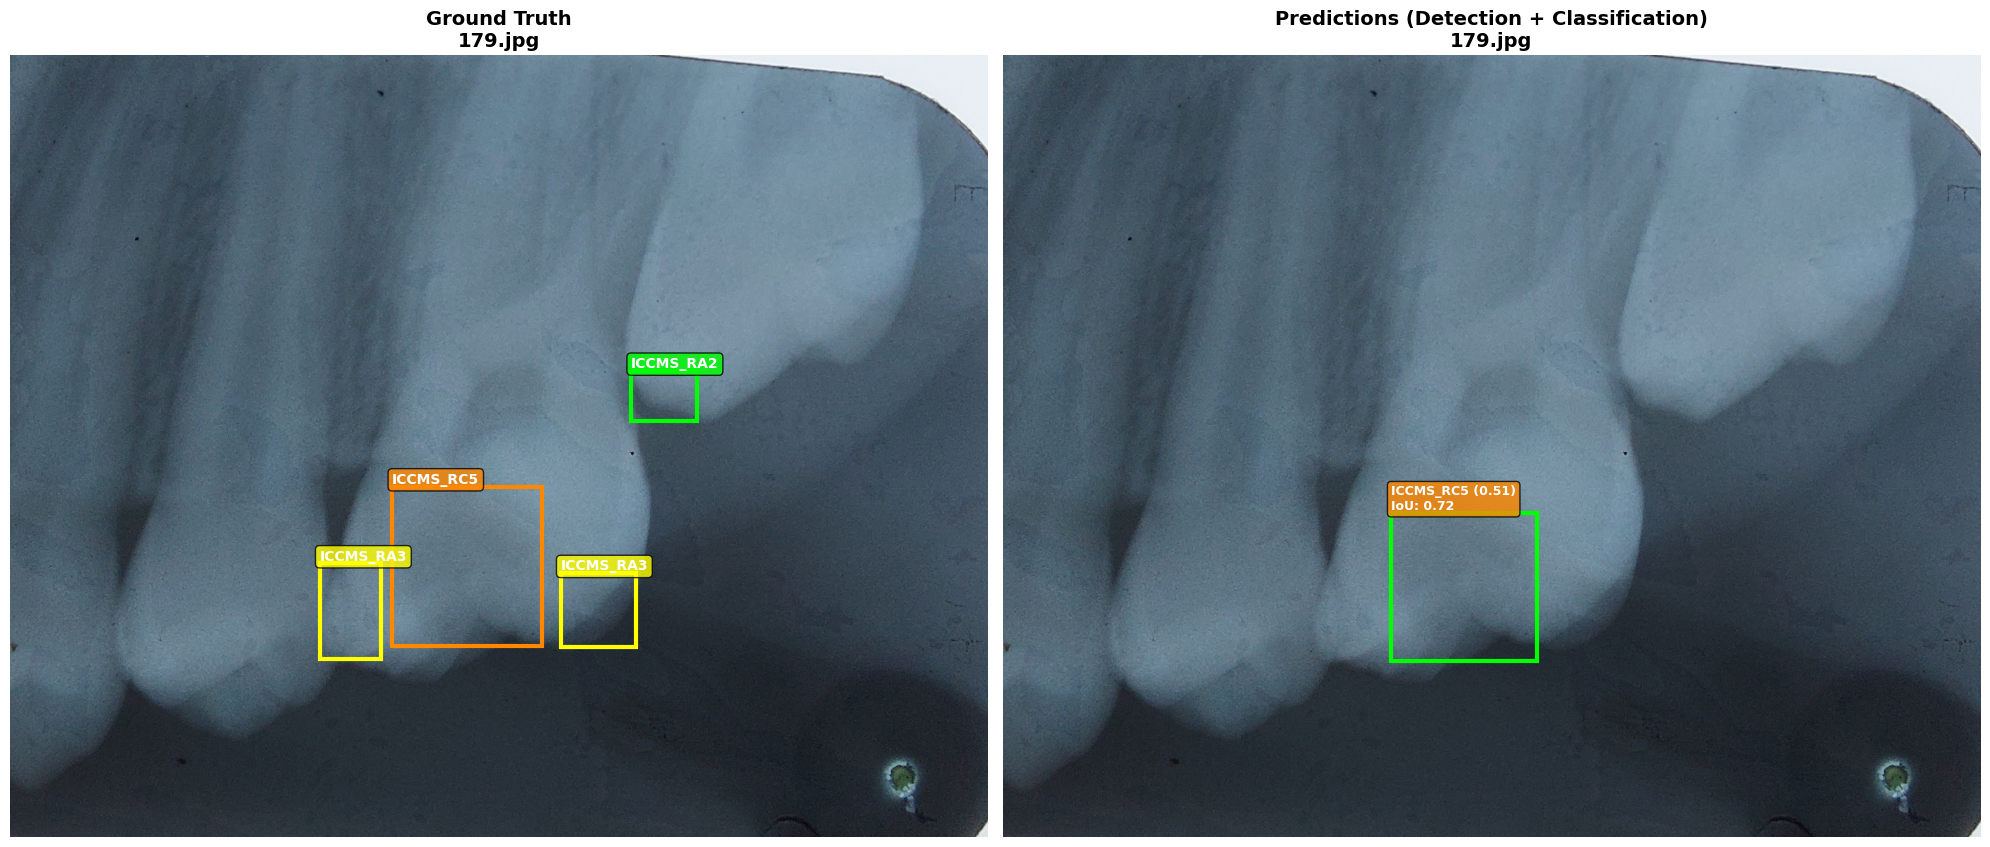

Processing 2/10: 4_1.jpg
Processing 3/10: 141_jpg.rf.f19926319fb140d06b8a447fa19ceeba.jpg


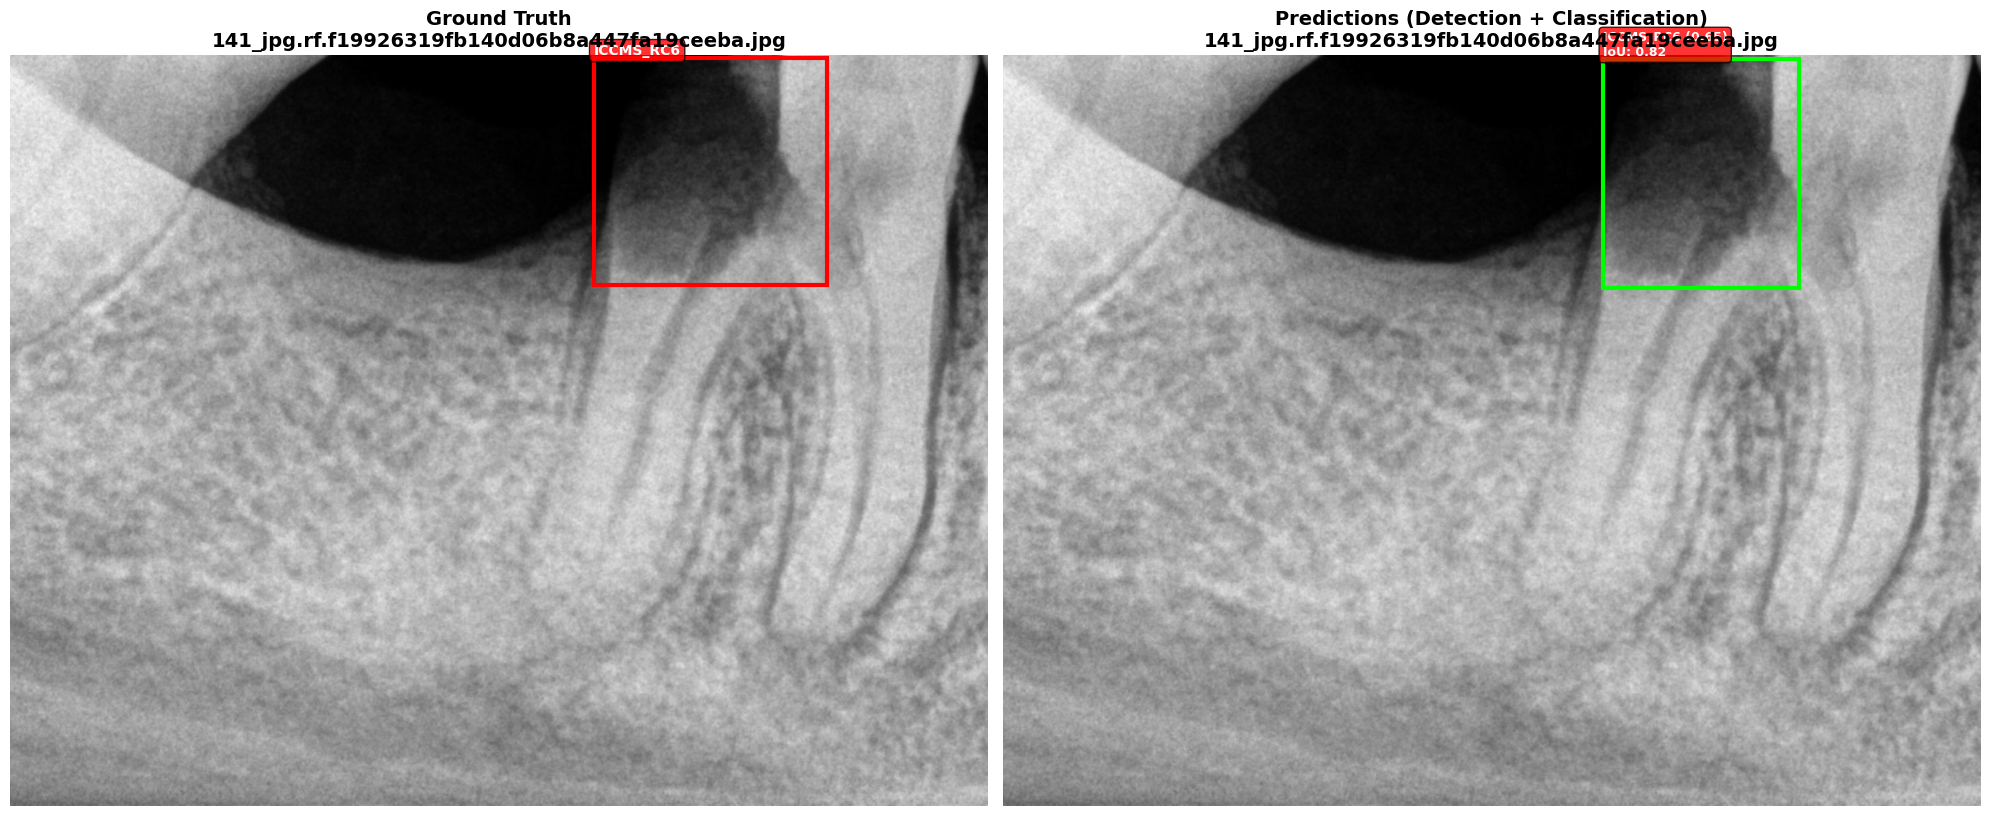

Processing 4/10: 279_jpg.rf.88cade54c5e0aa5344a2f1df80e81c44.jpg


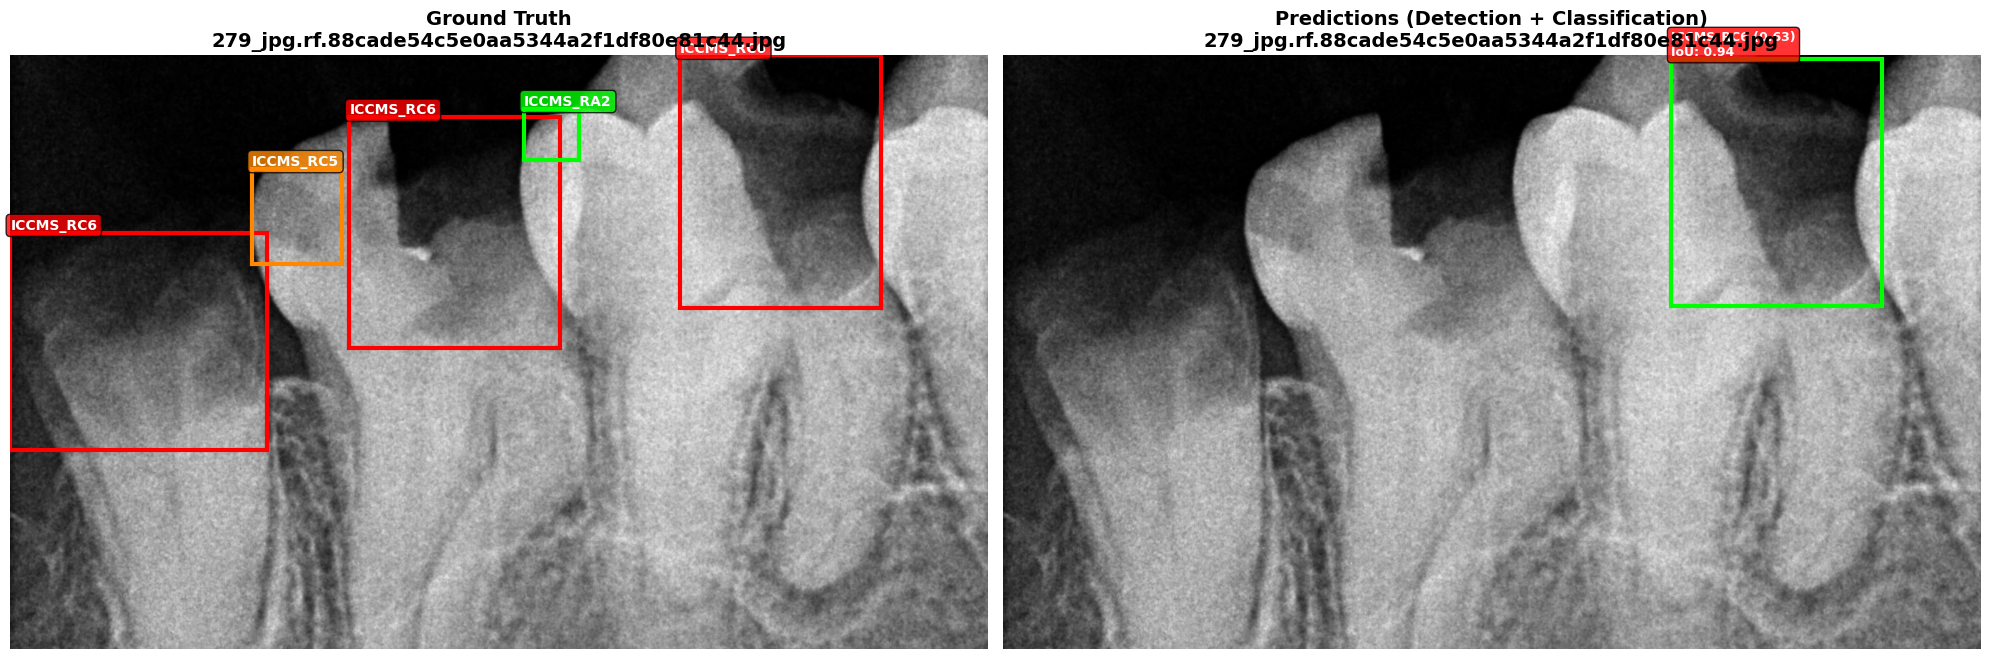

Processing 5/10: 346_jpg.rf.86d62567cdfa263a8f04535f5ac5ec36.jpg


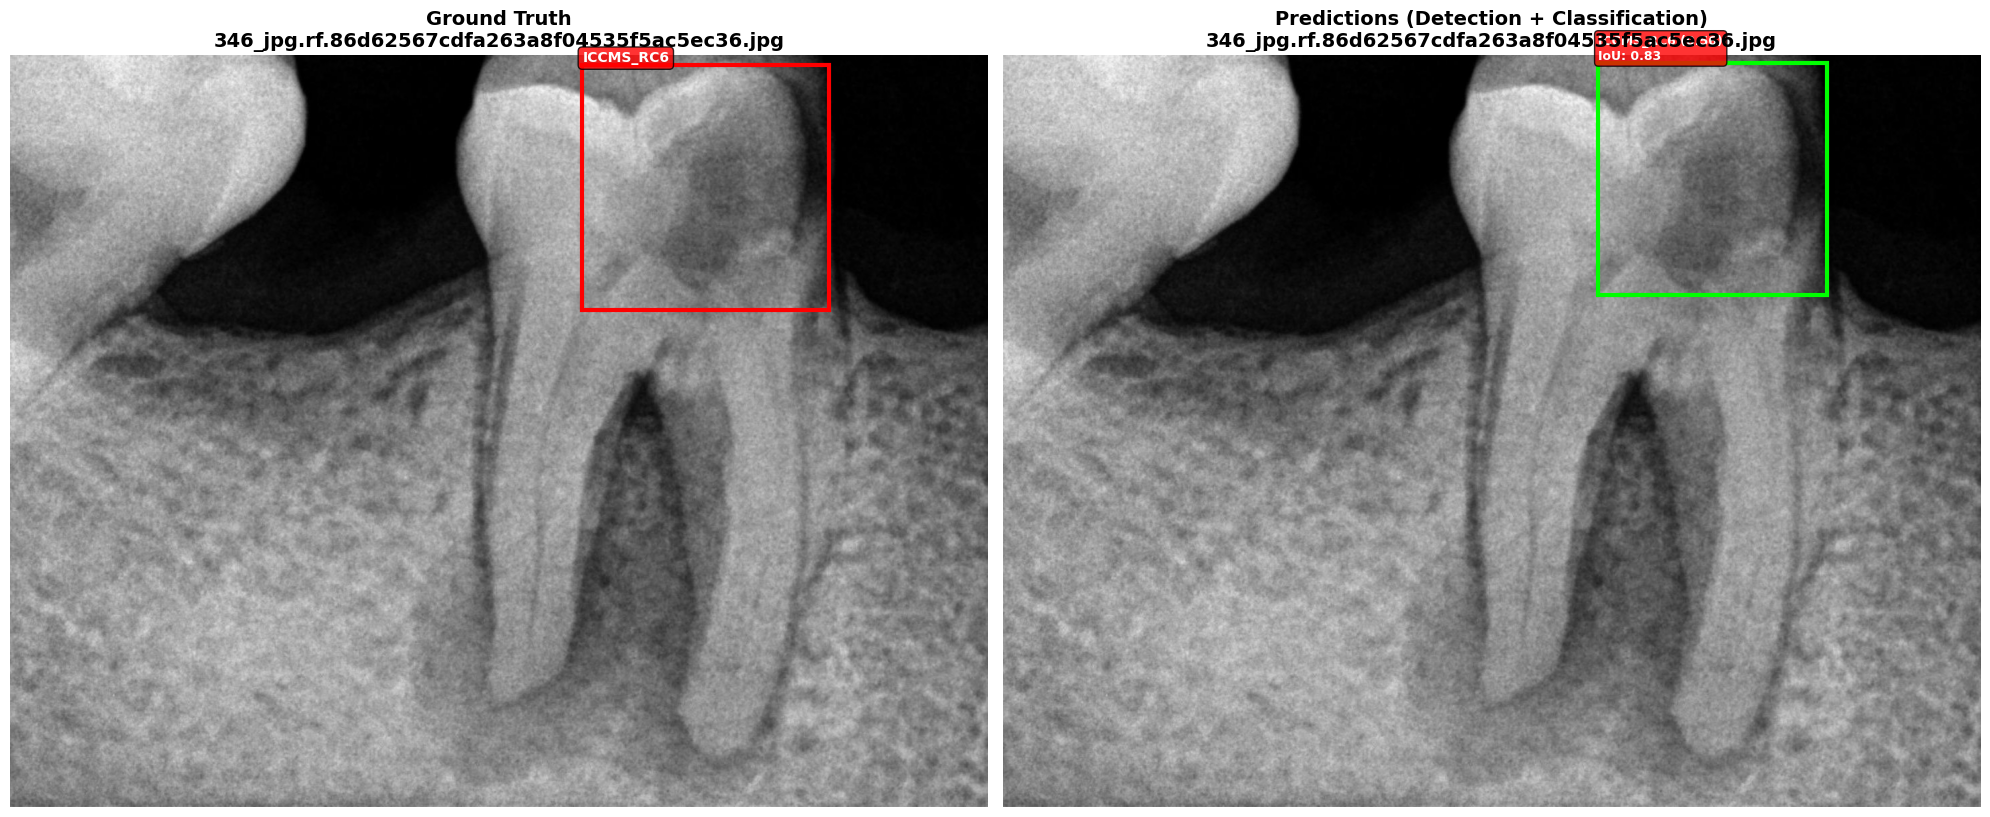

Processing 6/10: 366.jpg


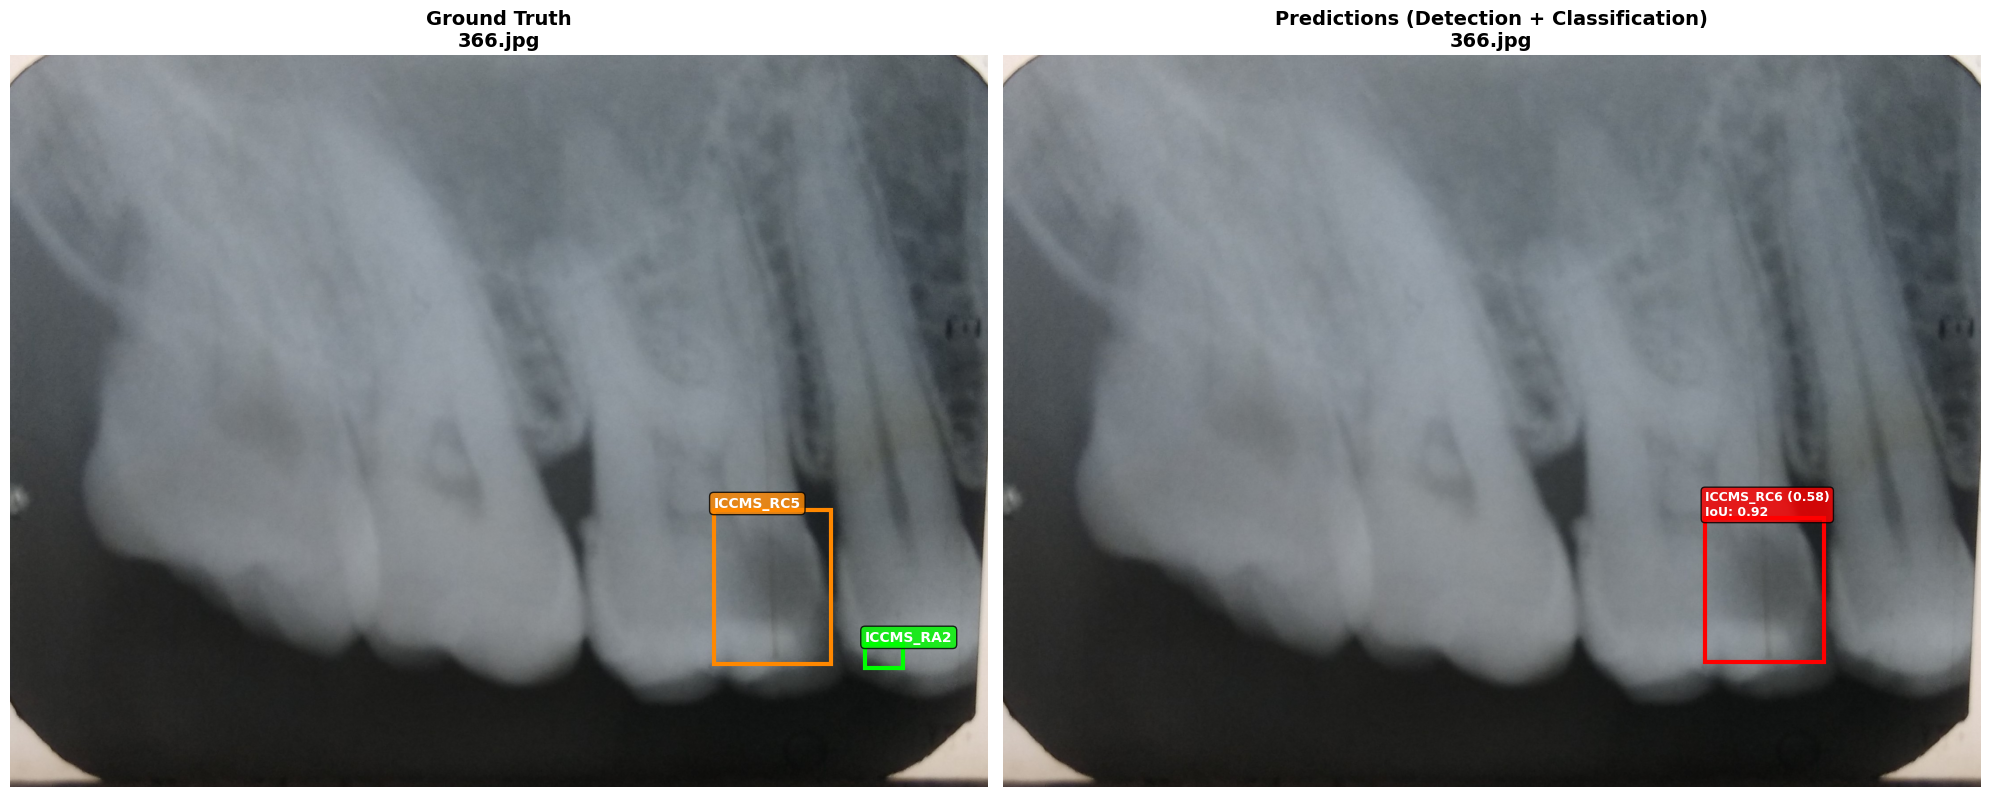

Processing 7/10: 467.jpg


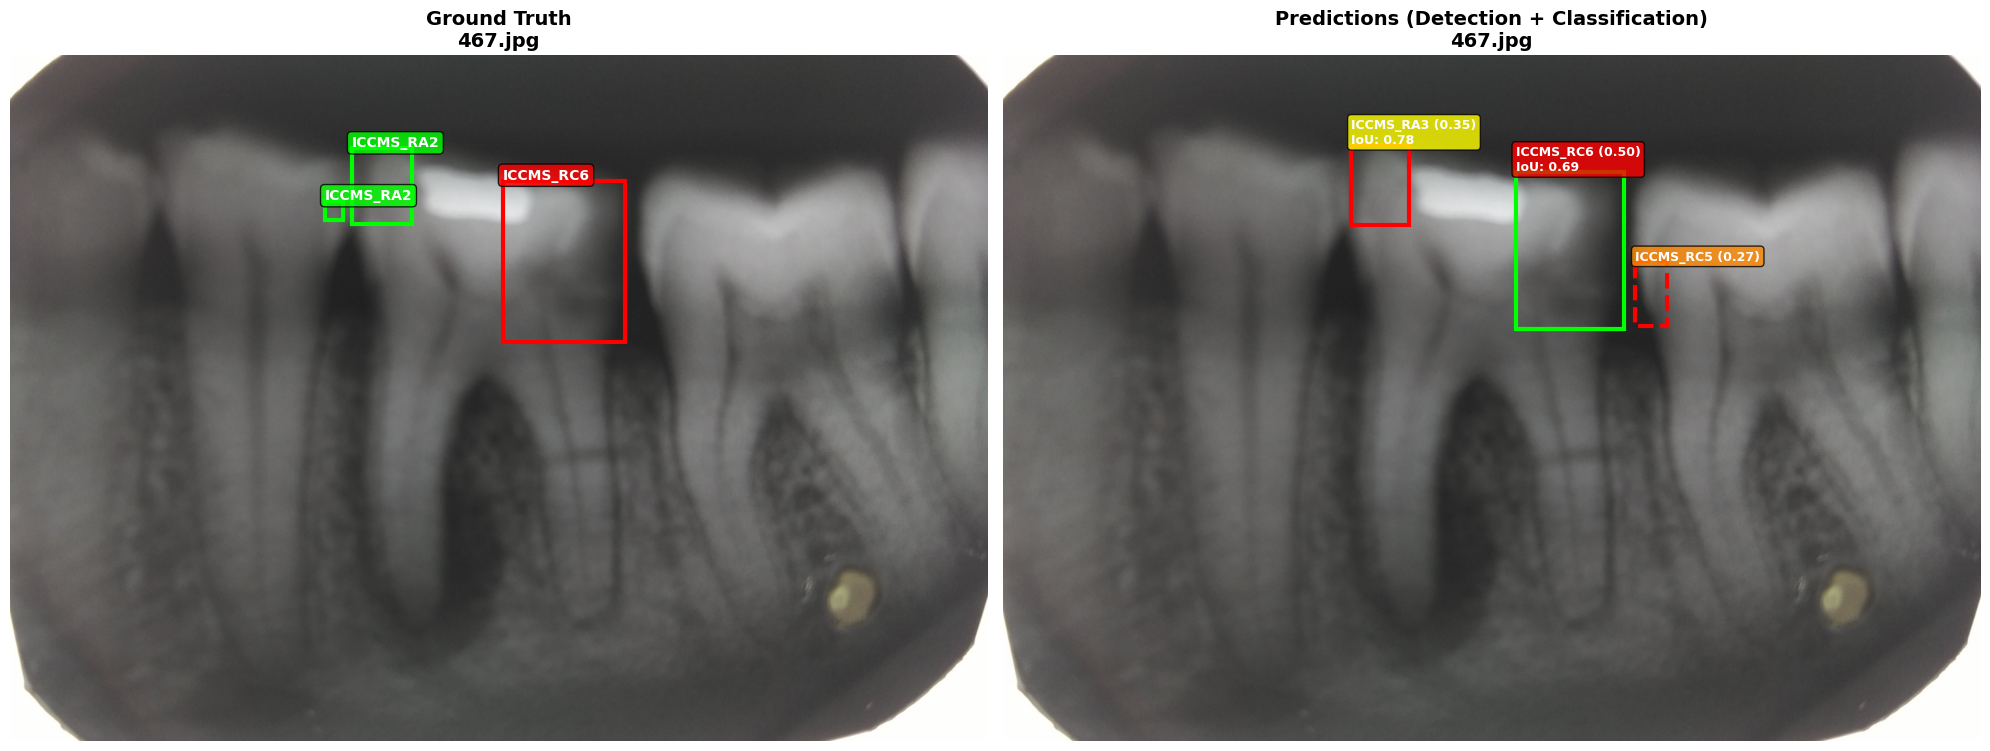

Processing 8/10: 041_jpg.rf.aa75a05dd4bd9771b8642de7e55b1167.jpg


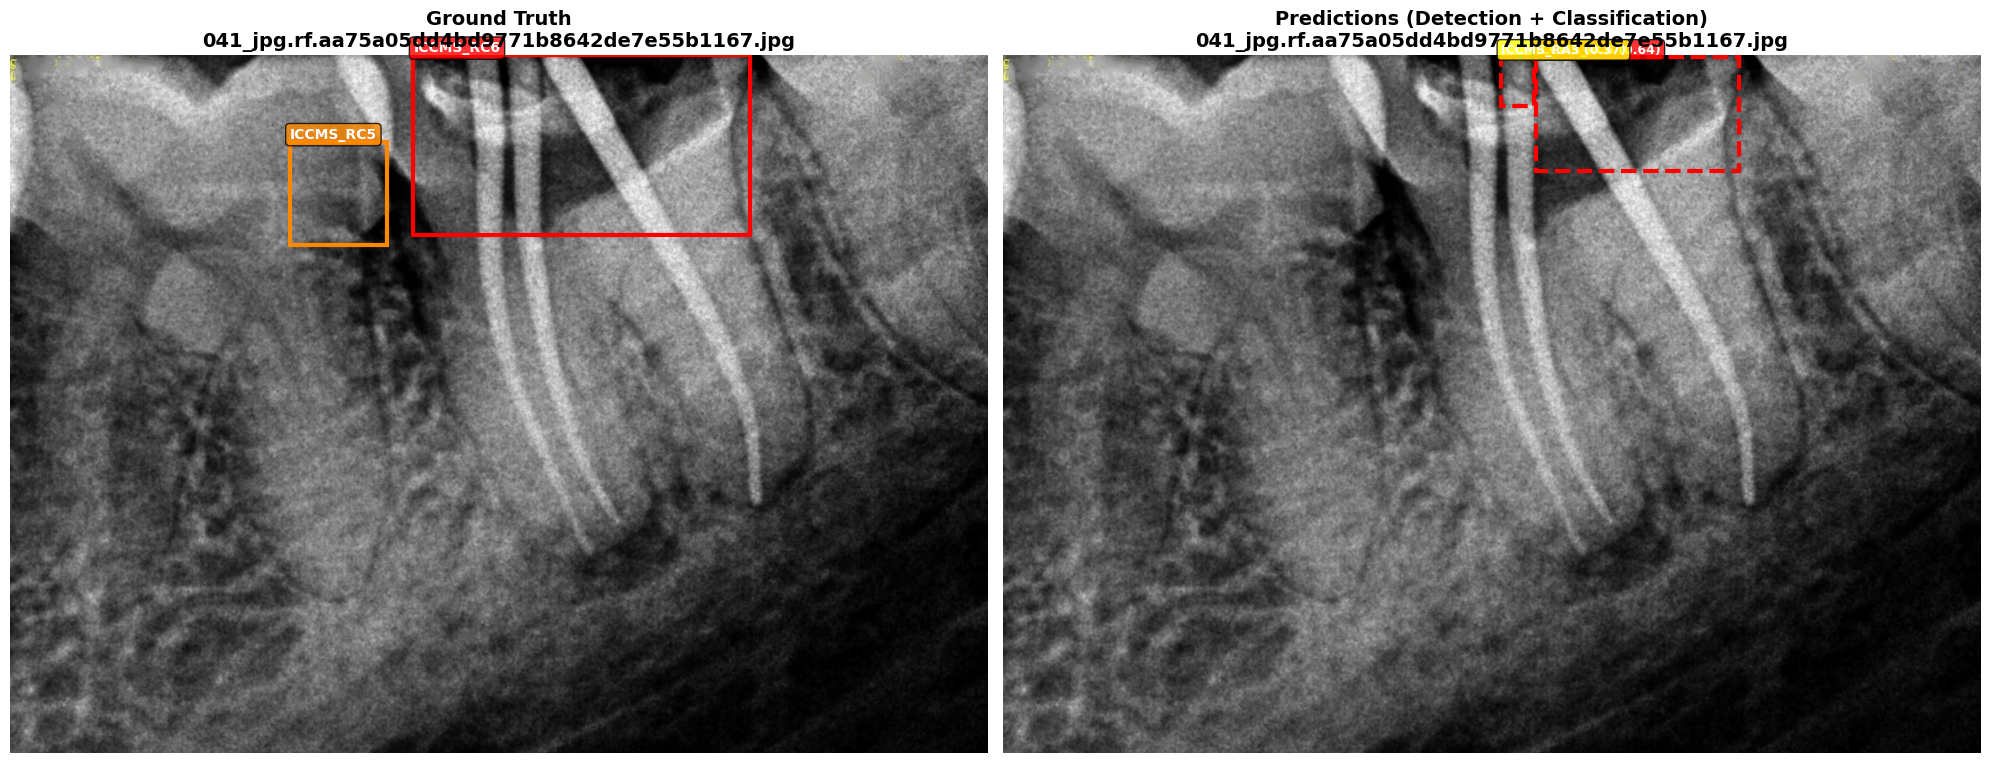

Processing 9/10: 12_1.jpg
Processing 10/10: 281_jpg.rf.ae2c96b64fd0580bad586223e9bb8853.jpg


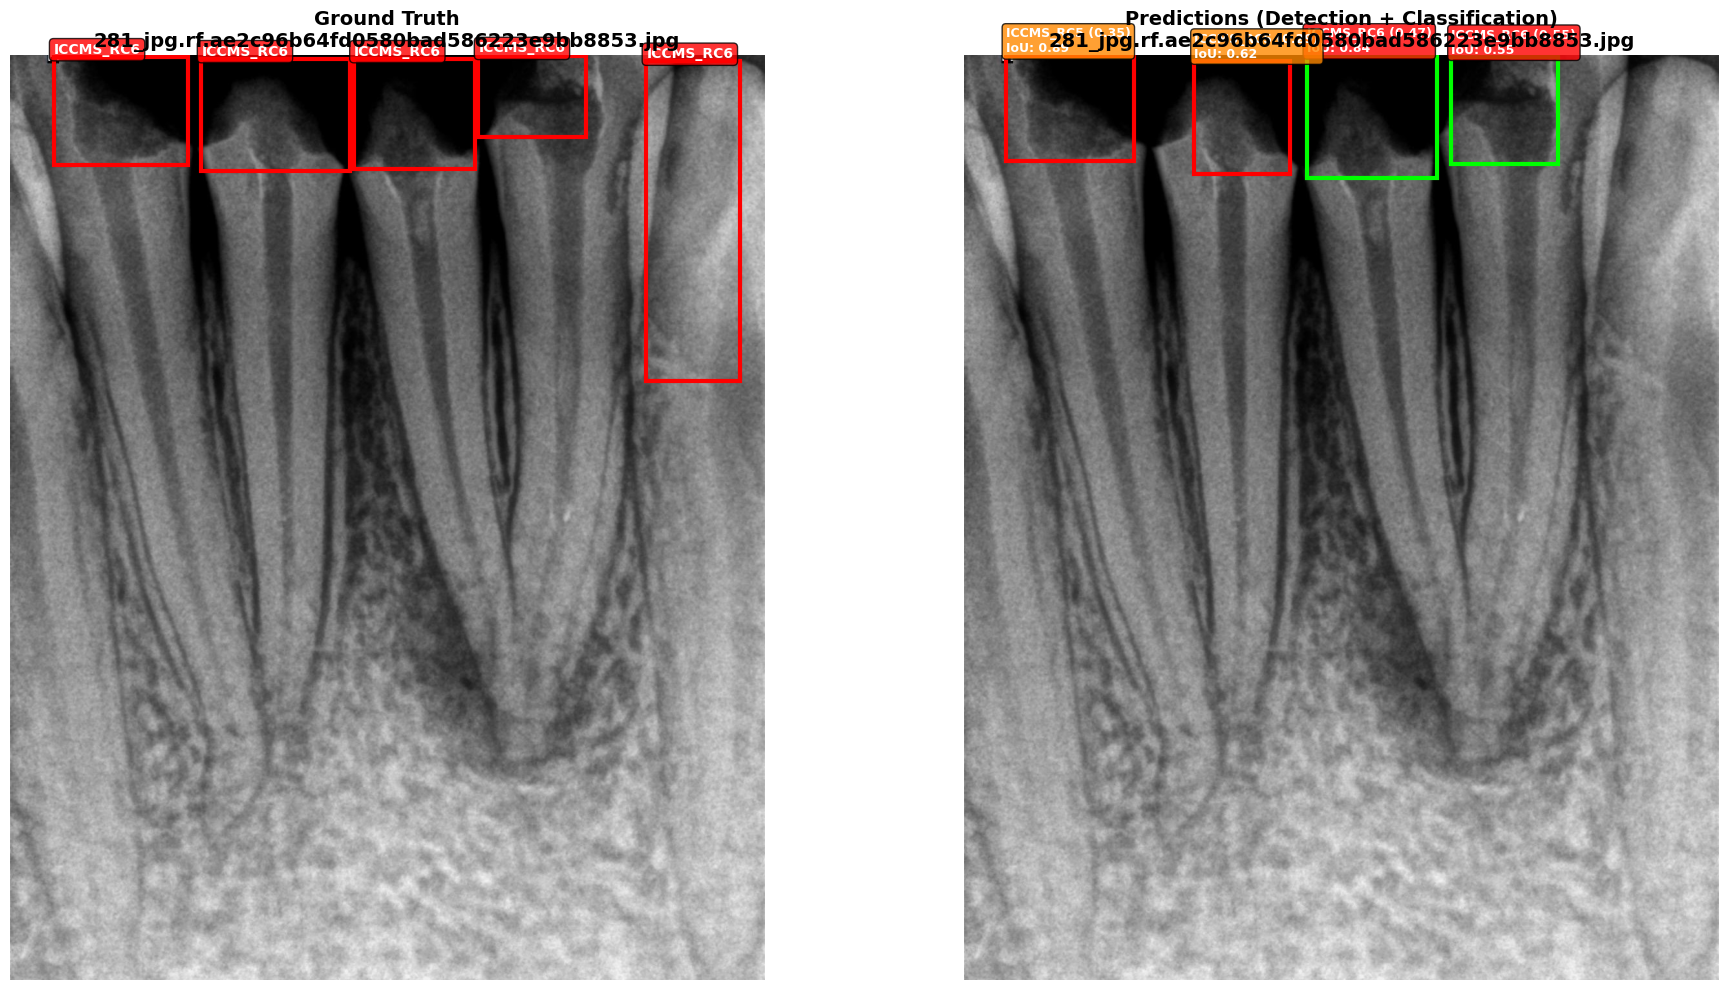


✓ Generated 10 visualizations

Legend:
  LEFT:  Ground truth boxes with class labels
  RIGHT: Predicted boxes with classification results
         - Solid green border = Correct detection + classification
         - Solid red border = Incorrect classification (but IoU ≥ 0.5)
         - Dashed border = Low IoU match (< 0.5)

VISUALIZATION COMPLETE!


In [ ]:
# ===================== VISUALIZATION: SIDE-BY-SIDE PREDICTIONS =====================

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

print("\n=== GENERATING VISUALIZATIONS ===\n")

# Color map for each class
CLASS_COLORS = {
    "ICCMS_RA2": "#00FF00",  # Green
    "ICCMS_RA3": "#FFFF00",  # Yellow
    "ICCMS_RC5": "#FF8800",  # Orange
    "ICCMS_RC6": "#FF0000",  # Red
}

def visualize_predictions(num_samples=10, seed=42):
    """
    Visualize side-by-side comparison of ground truth and predictions

    Args:
        num_samples: Number of test images to visualize
        seed: Random seed for reproducibility
    """
    random.seed(seed)

    # Select random test images that have ground truth
    available_images = [fname for fname in split_manifest["test_filenames"] if fname in gt_data]

    if len(available_images) == 0:
        print("⚠ No test images with ground truth found!")
        return

    sample_images = random.sample(available_images, min(num_samples, len(available_images)))

    for idx, fname in enumerate(sample_images):
        print(f"Processing {idx+1}/{len(sample_images)}: {fname}")

        img_path = os.path.join(IMAGES_DIR, fname)
        im = cv2.imread(img_path)
        if im is None:
            continue

        # Convert BGR to RGB for display
        im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

        # Get YOLO predictions
        results = yolo_model.predict(img_path, conf=0.25, iou=0.45,
                                    device=0 if torch.cuda.is_available() else None,
                                    verbose=False)

        preds = []
        if len(results) > 0 and results[0].boxes is not None:
            boxes = results[0].boxes
            for i in range(len(boxes)):
                x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy().astype(int)
                preds.append([x1, y1, x2, y2])

        # Get ground truth
        gts = gt_data[fname]

        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

        # ========== LEFT: GROUND TRUTH ==========
        ax1.imshow(im_rgb)
        ax1.set_title(f"Ground Truth\n{fname}", fontsize=14, fontweight='bold')
        ax1.axis('off')

        for gt in gts:
            x1, y1, x2, y2 = gt["bbox"]
            class_name = gt["class_name"]
            color = CLASS_COLORS[class_name]

            # Draw rectangle
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                    linewidth=3, edgecolor=color,
                                    facecolor='none', linestyle='-')
            ax1.add_patch(rect)

            # Add label with background
            ax1.text(x1, y1-5, class_name,
                    fontsize=10, color='white', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8))

        # ========== RIGHT: PREDICTIONS ==========
        ax2.imshow(im_rgb)
        ax2.set_title(f"Predictions (Detection + Classification)\n{fname}",
                     fontsize=14, fontweight='bold')
        ax2.axis('off')

        # Match predictions to ground truth and classify
        for pred_box in preds:
            x1, y1, x2, y2 = pred_box

            # Find best matching GT (if any)
            best_iou = 0.0
            best_gt_idx = -1
            for gi, gt in enumerate(gts):
                iou = compute_iou_xyxy(pred_box, gt["bbox"])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gi

            # Classify the detection
            margin = 16
            y1_m = max(0, y1 - margin)
            y2_m = min(im.shape[0], y2 + margin)
            x1_m = max(0, x1 - margin)
            x2_m = min(im.shape[1], x2 + margin)

            crop = im[y1_m:y2_m, x1_m:x2_m]

            if crop.size > 0:
                cls_out = classify_crop(crop)
                pred_class = cls_out["pred_name"]
                confidence = cls_out["conf"]
                color = CLASS_COLORS[pred_class]

                # Determine if prediction is correct (matched and same class)
                is_correct = False
                if best_iou >= 0.5 and best_gt_idx >= 0:
                    gt_class = gts[best_gt_idx]["class_name"]
                    is_correct = (pred_class == gt_class)

                # Draw rectangle (green border if correct, red if incorrect)
                border_color = '#00FF00' if is_correct else '#FF0000'
                linestyle = '-' if best_iou >= 0.5 else '--'  # Dashed if no match

                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                        linewidth=3, edgecolor=border_color,
                                        facecolor='none', linestyle=linestyle)
                ax2.add_patch(rect)

                # Add label
                label = f"{pred_class} ({confidence:.2f})"
                if best_iou >= 0.5:
                    label += f"\nIoU: {best_iou:.2f}"

                ax2.text(x1, y1-5, label,
                        fontsize=9, color='white', fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8))

        plt.tight_layout()
        plt.savefig(f'visualization_{idx+1}_{fname}', dpi=150, bbox_inches='tight')
        plt.show()

    print(f"\n✓ Generated {len(sample_images)} visualizations")
    print("\nLegend:")
    print("  LEFT:  Ground truth boxes with class labels")
    print("  RIGHT: Predicted boxes with classification results")
    print("         - Solid green border = Correct detection + classification")
    print("         - Solid red border = Incorrect classification (but IoU ≥ 0.5)")
    print("         - Dashed border = Low IoU match (< 0.5)")

# Run visualization
visualize_predictions(num_samples=10, seed=42)

print("\n" + "="*80)
print("VISUALIZATION COMPLETE!")
print("="*80)

In [ ]:
# ===================== VISUALIZATION: SIDE-BY-SIDE PREDICTIONS =====================

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

print("\n=== GENERATING VISUALIZATIONS ===\n")

# Color map for each class
CLASS_COLORS = {
    "ICCMS_RA2": "#00FF00",  # Green
    "ICCMS_RA3": "#FFFF00",  # Yellow
    "ICCMS_RC5": "#FF8800",  # Orange
    "ICCMS_RC6": "#FF0000",  # Red
}

def visualize_predictions(num_samples=10, seed=42):
    """
    Visualize side-by-side comparison of ground truth and predictions

    Args:
        num_samples: Number of test images to visualize
        seed: Random seed for reproducibility
    """
    random.seed(seed)

    # Select random test images that have ground truth
    available_images = [fname for fname in split_manifest["test_filenames"] if fname in gt_data]

    if len(available_images) == 0:
        print("⚠ No test images with ground truth found!")
        return

    sample_images = random.sample(available_images, min(num_samples, len(available_images)))

    for idx, fname in enumerate(sample_images):
        print(f"Processing {idx+1}/{len(sample_images)}: {fname}")

        img_path = os.path.join(IMAGES_DIR, fname)
        im = cv2.imread(img_path)
        if im is None:
            continue

        # Convert BGR to RGB for display
        im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

        # Get YOLO predictions
        results = yolo_model.predict(img_path, conf=0.25, iou=0.45,
                                    device=0 if torch.cuda.is_available() else None,
                                    verbose=False)

        preds = []
        if len(results) > 0 and results[0].boxes is not None:
            boxes = results[0].boxes
            for i in range(len(boxes)):
                x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy().astype(int)
                preds.append([x1, y1, x2, y2])

        # Get ground truth
        gts = gt_data[fname]

        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

        # ========== LEFT: GROUND TRUTH ==========
        ax1.imshow(im_rgb)
        ax1.set_title(f"Ground Truth\n{fname}", fontsize=14, fontweight='bold')
        ax1.axis('off')

        for gt in gts:
            x1, y1, x2, y2 = gt["bbox"]
            class_name = gt["class_name"]
            color = CLASS_COLORS[class_name]

            # Draw rectangle
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                    linewidth=3, edgecolor=color,
                                    facecolor='none', linestyle='-')
            ax1.add_patch(rect)

            # Add label with background
            ax1.text(x1, y1-5, class_name,
                    fontsize=10, color='white', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8))

        # ========== RIGHT: PREDICTIONS ==========
        ax2.imshow(im_rgb)
        ax2.set_title(f"Predictions (Detection + Classification)\n{fname}",
                     fontsize=14, fontweight='bold')
        ax2.axis('off')

        # Match predictions to ground truth and classify
        for pred_box in preds:
            x1, y1, x2, y2 = pred_box

            # Find best matching GT (if any)
            best_iou = 0.0
            best_gt_idx = -1
            for gi, gt in enumerate(gts):
                iou = compute_iou_xyxy(pred_box, gt["bbox"])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gi

            # Classify the detection
            margin = 16
            y1_m = max(0, y1 - margin)
            y2_m = min(im.shape[0], y2 + margin)
            x1_m = max(0, x1 - margin)
            x2_m = min(im.shape[1], x2 + margin)

            crop = im[y1_m:y2_m, x1_m:x2_m]

            if crop.size > 0:
                cls_out = classify_crop(crop)
                pred_class = cls_out["pred_name"]
                confidence = cls_out["conf"]
                color = CLASS_COLORS[pred_class]

                # Determine if prediction is correct (matched and same class)
                is_correct = False
                if best_iou >= 0.5 and best_gt_idx >= 0:
                    gt_class = gts[best_gt_idx]["class_name"]
                    is_correct = (pred_class == gt_class)

                # Draw rectangle (green border if correct, red if incorrect)
                border_color = '#00FF00' if is_correct else '#FF0000'
                linestyle = '-' if best_iou >= 0.5 else '--'  # Dashed if no match

                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                        linewidth=3, edgecolor=border_color,
                                        facecolor='none', linestyle=linestyle)
                ax2.add_patch(rect)

                # Add label
                label = f"{pred_class} ({confidence:.2f})"
                if best_iou >= 0.5:
                    label += f"\nIoU: {best_iou:.2f}"

                ax2.text(x1, y1-5, label,
                        fontsize=9, color='white', fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8))

        plt.tight_layout()
        plt.savefig(f'visualization_{idx+1}_{fname}', dpi=150, bbox_inches='tight')
        plt.show()

    print(f"\n✓ Generated {len(sample_images)} visualizations")
    print("\nLegend:")
    print("  LEFT:  Ground truth boxes with class labels")
    print("  RIGHT: Predicted boxes with classification results")
    print("         - Solid green border = Correct detection + classification")
    print("         - Solid red border = Incorrect classification (but IoU ≥ 0.5)")
    print("         - Dashed border = Low IoU match (< 0.5)")

# Run visualization
visualize_predictions(num_samples=30, seed=42)

print("\n" + "="*80)
print("VISUALIZATION COMPLETE!")
print("="*80)


=== GENERATING VISUALIZATIONS ===



NameError: name 'gt_data' is not defined

In [ ]:
# ===================== DEBUGGING AND FIX =====================

# Check if there's a conflicting definition
import inspect
if 'CariesSwinDataset' in dir():
    print(f"CariesSwinDataset exists, checking its source...")
    try:
        print(inspect.getsource(CariesSwinDataset))
    except:
        print("Cannot get source - might be corrupted")
    # Delete it
    del CariesSwinDataset
    print("✓ Deleted old CariesSwinDataset")

# Also check for Dataset itself
from torch.utils.data import Dataset as TorchDataset
print(f"Dataset class: {TorchDataset}")

# Now define with explicit inheritance
import torch
import cv2
import numpy as np
from pycocotools import mask as maskUtils
from torch.utils.data import Dataset as BaseDataset

class CariesSwinDataset(BaseDataset):
    """Dataset for Swin training on cropped caries images"""

    def _init_(self, images_list, anns_by_image, img_dir, transforms=None, use_clahe=True):
        super()._init_()
        self.images = images_list
        self.anns_by_image = anns_by_image
        self.img_dir = img_dir
        self.transforms = transforms
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) if use_clahe else None
        print(f"  Dataset initialized with {len(images_list)} images")

    def _len_(self):
        return len(self.images)

    def _build_mask(self, img_info, h, w):
        masks = np.zeros((NUM_CLASSES_FINE, h, w), dtype=np.uint8)
        for ann in self.anns_by_image[img_info["id"]]:
            c_idx = ann["category_id"]
            seg = ann.get("segmentation", [])
            if seg:
                rles = maskUtils.frPyObjects(seg, h, w)
                m = maskUtils.decode(rles)
                if m.ndim == 3:
                    m = np.any(m, axis=2).astype(np.uint8)
                else:
                    m = m.astype(np.uint8)
                masks[c_idx] = np.logical_or(masks[c_idx], m).astype(np.uint8)
        return masks

    def _getitem_(self, idx):
        info = self.images[idx]
        path = os.path.join(self.img_dir, info["file_name"])
        img = cv2.imread(path)
        if img is None:
            return self._getitem_((idx+1) % len(self))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        if self.clahe:
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            lab[:,:,0] = self.clahe.apply(lab[:,:,0])
            img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        masks = self._build_mask(info, h, w)

        if self.transforms:
            tr = self.transforms(image=img, masks=[m for m in masks])
            img = tr["image"]
            masks = np.stack(tr["masks"], axis=0).astype(np.float32)

        img = (img.astype(np.float32) / 255.0).transpose(2, 0, 1)

        gt_class = -1
        anns = self.anns_by_image[info["id"]]
        if len(anns) > 0:
            gt_class = anns[0]["category_id"]

        return {
            "image": torch.tensor(img, dtype=torch.float32),
            "mask": torch.tensor(masks, dtype=torch.float32),
            "gt_class": gt_class
        }

# Test that the class is properly defined
print(f"✓ Class defined: {CariesSwinDataset}")
print(f"✓ Class _init_ signature: {inspect.signature(CariesSwinDataset._init_)}")

# Now try to create an instance
print("\nCreating train dataset...")
train_ds = CariesSwinDataset(splits["train"], swin_anns_by_image, CROPPED_IMG_DIR, train_tfms)

print("\nCreating val dataset...")
val_ds = CariesSwinDataset(splits["val"], swin_anns_by_image, CROPPED_IMG_DIR, val_tfms)

print("\nCreating test dataset...")
test_ds = CariesSwinDataset(splits["test"], swin_anns_by_image, CROPPED_IMG_DIR, val_tfms)

print(f"\n✓ All datasets created: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")

# Create weighted sampler
counts = np.zeros(NUM_CLASSES_FINE)
for img in splits["train"]:
    if len(swin_anns_by_image[img["id"]]) > 0:
        counts[swin_anns_by_image[img["id"]][0]["category_id"]] += 1

weights = 1.0 / (counts + 1.0)
sample_weights = []
for img in splits["train"]:
    if len(swin_anns_by_image[img["id"]]) > 0:
        c = swin_anns_by_image[img["id"]][0]["category_id"]
        sample_weights.append(float(max(0.1, weights[c])))
    else:
        sample_weights.append(0.1)

# Create dataloaders
from torch.utils.data import DataLoader, WeightedRandomSampler

train_loader = DataLoader(
    train_ds,
    batch_size=8,
    sampler=WeightedRandomSampler(sample_weights, num_samples=len(train_ds)*2, replacement=True),
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

print(f"✓ DataLoaders created successfully!")

CariesSwinDataset exists, checking its source...
Cannot get source - might be corrupted
✓ Deleted old CariesSwinDataset
Dataset class: <class 'torch.utils.data.dataset.Dataset'>
✓ Class defined: <class '__main__.CariesSwinDataset'>
✓ Class _init_ signature: (self, images_list, anns_by_image, img_dir, transforms=None, use_clahe=True)

Creating train dataset...


TypeError: CariesSwinDataset() takes no arguments

In [ ]:


# =======================  SWIN: DATASETS & MODEL  ============================
# Map cropped images back to split using original filename
orig_id2fname = {img["id"]: os.path.basename(img["file_name"]) for img in coco_full["images"]}
def which_split_for_crop(img_info):
    orig_fname = img_info.get("original_file_name", None)
    if orig_fname is None:
        # fallback via id (older crops)
        orig_id = img_info.get("original_image_id", None)
        orig_fname = orig_id2fname.get(orig_id, None)
    if orig_fname is None: return "discard"
    bn = os.path.basename(orig_fname)
    if bn in split_manifest["train_filenames"]: return "train"
    if bn in split_manifest["val_filenames"]:   return "val"
    if bn in split_manifest["test_filenames"]:  return "test"
    return "discard"

swin_images_info = {img["id"]: img for img in swin_coco["images"]}
swin_anns_by_image = defaultdict(list)
for a in swin_coco["annotations"]:
    swin_anns_by_image[a["image_id"]].append(a)

splits = {"train": [], "val": [], "test": []}
for img in swin_coco["images"]:
    s = which_split_for_crop(img)
    if s != "discard":
        splits[s].append(img)

print(f"SWIN split (crops): train={len(splits['train'])}, val={len(splits['val'])}, test={len(splits['test'])}")

# Albumentations
train_tfms = A.Compose([
    A.Resize(224,224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.RandomBrightnessContrast(0.2,0.2,p=0.5),
    A.HueSaturationValue(10,20,20,p=0.3),
    A.OneOf([
        A.GaussianBlur(blur_limit=3, p=1.0),
        A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
    ], p=0.2),
])
val_tfms = A.Compose([A.Resize(224,224)])

class SwinDataset(Dataset):
    def __init__(self, images_list, anns_by_image, img_dir, transforms=None, use_clahe=True):
        self.images = images_list
        self.anns_by_image = anns_by_image
        self.img_dir = img_dir
        self.transforms = transforms
        self.clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8)) if use_clahe else None

    def __len__(self): return len(self.images)

    def _build_mask(self, img_info, h, w):
        masks = np.zeros((NUM_CLASSES_FINE, h, w), dtype=np.uint8)
        for ann in self.anns_by_image[img_info["id"]]:
            c_idx = ann["category_id"]
            seg = ann.get("segmentation", [])
            if seg:
                rles = maskUtils.frPyObjects(seg, h, w)
                m = maskUtils.decode(rles)
                if m.ndim == 3: m = np.any(m, axis=2).astype(np.uint8)
                else:           m = m.astype(np.uint8)
                masks[c_idx] = np.logical_or(masks[c_idx], m).astype(np.uint8)
        return masks

    def __getitem__(self, idx):
        info = self.images[idx]
        path = os.path.join(self.img_dir, info["file_name"])
        img = cv2.imread(path)
        if img is None:
            return self.__getitem__((idx+1)%len(self))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h,w = img.shape[:2]
        if self.clahe:
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            lab[:,:,0] = self.clahe.apply(lab[:,:,0]); img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        masks = self._build_mask(info, h, w)

        if self.transforms:
            tr = self.transforms(image=img, masks=[m for m in masks])
            img = tr["image"]; masks = np.stack(tr["masks"], axis=0).astype(np.float32)

        img = (img.astype(np.float32)/255.0).transpose(2,0,1)
        # single GT class for classification confusion matrix
        gt_class = -1
        anns = self.anns_by_image[info["id"]]
        if len(anns)>0: gt_class = anns[0]["category_id"]

        return {
            "image": torch.tensor(img, dtype=torch.float32),
            "mask":  torch.tensor(masks, dtype=torch.float32),
            "gt_class": gt_class
        }

train_ds = SwinDataset(splits["train"], swin_anns_by_image, CROPPED_IMG_DIR, train_tfms)
val_ds   = SwinDataset(splits["val"],   swin_anns_by_image, CROPPED_IMG_DIR, val_tfms)
test_ds  = SwinDataset(splits["test"],  swin_anns_by_image, CROPPED_IMG_DIR, val_tfms)

# Sampling weights (simple inverse count per class of the first ann)
counts = np.zeros(NUM_CLASSES_FINE)
for img in splits["train"]:
    if len(swin_anns_by_image[img["id"]])>0:
        counts[swin_anns_by_image[img["id"]][0]["category_id"]]+=1
weights = 1.0 / (counts + 1.0)
sample_weights=[]
for img in splits["train"]:
    if len(swin_anns_by_image[img["id"]])>0:
        c = swin_anns_by_image[img["id"]][0]["category_id"]
        sample_weights.append(float(max(0.1, weights[c])))
    else:
        sample_weights.append(0.1)

train_loader = DataLoader(train_ds, batch_size=8,
                          sampler=WeightedRandomSampler(sample_weights, num_samples=len(train_ds)*2, replacement=True),
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)


SWIN split (crops): train=706, val=102, test=223


NameError: name 'NUM_CLASSES_FINE' is not defined

In [ ]:
# Ensure correct timm version for segmentation_models_pytorch
!pip install -q timm==0.4.12

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

# Uses global NUM_CLASSES_FINE defined earlier
class SwinUNet(nn.Module):
    def _init_(self,
                 encoder_name="swin_tiny_patch4_window7_224",
                 pretrained=True,
                 num_classes=NUM_CLASSES_FINE):
        super()._init_()
        # Create backbone with no classifier head
        self.swin = timm.create_model(
            encoder_name,
            pretrained=pretrained,
            img_size=224,
            num_classes=0,   # no classification head
        )

        # Infer channel dims of the 4 stages
        self._channels = self._get_channels()
        C0, C1, C2, C3 = self._channels

        # UNet-style decoder
        self.center = self._block(C3, C3)
        self.up3    = self._up(C3, C2, C2)
        self.up2    = self._up(C2, C1, C1)
        self.up1    = self._up(C1, C0, C0)
        self.up0    = nn.Sequential(
            nn.Upsample(scale_factor=4, mode="bilinear", align_corners=False),
            self._block(C0, 64),
        )
        self.final  = nn.Conv2d(64, num_classes, kernel_size=1)

    # ---------------- helpers ----------------
    def _block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def _up(self, in_ch, skip_ch, out_ch):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            nn.Conv2d(in_ch + skip_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def _swin_stem(self, x):
        # Common Swin patch embedding + pos-embed + dropout stem
        x = self.swin.patch_embed(x)

        abs_pe = getattr(self.swin, "absolute_pos_embed", None)
        if abs_pe is not None:
            x = x + abs_pe

        # Old timm versions: pos_drop; newer: drop
        if hasattr(self.swin, "pos_drop"):
            x = self.swin.pos_drop(x)
        elif hasattr(self.swin, "drop"):
            x = self.swin.drop(x)

        return x

    def _extract_feats(self, x):
        """
        Run through Swin layers and return 4 feature maps as NCHW.
        This handles both (B,L,C) and (B,H,W,C)/(B,C,H,W) layouts
        depending on timm version.
        """
        x = self._swin_stem(x)
        feats = []

        for layer in self.swin.layers:
            x = layer(x)

            if x.ndim == 3:
                # (B, L, C) -> (B, C, H, W)
                B, L, C = x.shape
                H = W = int(L ** 0.5)
                feat = x.view(B, H, W, C).permute(0, 3, 1, 2).contiguous()
            elif x.ndim == 4:
                # Could be (B, H, W, C) or (B, C, H, W)
                if x.shape[1] <= 16 and x.shape[-1] > 16:
                    # Likely (B, H, W, C)
                    B, H, W, C = x.shape
                    feat = x.permute(0, 3, 1, 2).contiguous()
                else:
                    # Assume already (B, C, H, W)
                    feat = x
            else:
                raise RuntimeError(f"Unexpected Swin feature shape: {x.shape}")

            feats.append(feat)

        # We expect 4 stages
        if len(feats) != 4:
            # In case timm changes, at least take last 4
            feats = feats[-4:]
        return feats

    def _get_channels(self):
        self.swin.eval()
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            feats = self._extract_feats(dummy)
        return [f.shape[1] for f in feats]

    # ---------------- forward ----------------
    def forward(self, x):
        orig_size = x.shape[-2:]  # (H, W)
        f0, f1, f2, f3 = self._extract_feats(x)

        c  = self.center(f3)
        d3 = self.up3(torch.cat([
            F.interpolate(c,  size=f2.shape[-2:], mode="bilinear", align_corners=False),
            f2
        ], dim=1))
        d2 = self.up2(torch.cat([
            F.interpolate(d3, size=f1.shape[-2:], mode="bilinear", align_corners=False),
            f1
        ], dim=1))
        d1 = self.up1(torch.cat([
            F.interpolate(d2, size=f0.shape[-2:], mode="bilinear", align_corners=False),
            f0
        ], dim=1))

        d0   = self.up0(d1)
        out  = self.final(d0)
        out  = F.interpolate(out, size=orig_size, mode="bilinear", align_corners=False)
        return out

In [ ]:
# ----------------------  SWIN: TEST EVALUATION  ------------------------------
from sklearn.metrics import confusion_matrix

def eval_swin_test(best_path):
    # load model with same architecture
    model = SwinUNet(num_classes=NUM_CLASSES_FINE).to(DEVICE)
    ckpt = torch.load(best_path, map_location=DEVICE, weights_only=False)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    def predict_tta(x):
        with torch.no_grad():
            p1 = torch.sigmoid(model(x))
            p2 = torch.sigmoid(model(torch.flip(x, [3])))
        return (p1 + p2) / 2

    all_gt, all_pred = [], []
    mets = []

    with torch.no_grad():
        for b in tqdm(test_loader, desc="SWIN Test"):
            imgs = b["image"].to(DEVICE)
            masks = b["mask"].to(DEVICE)
            gt_classes = b["gt_class"].numpy()

            probs = predict_tta(imgs)
            # classification prediction from mean prob per class
            class_probs = probs.mean(dim=(2, 3))
            pred_classes = class_probs.argmax(dim=1).cpu().numpy()

            all_gt.extend(gt_classes)
            all_pred.extend(pred_classes)

            mets.append(compute_seg_metrics(probs, masks, thr=0.5))

    cm = confusion_matrix(all_gt, all_pred, labels=list(range(NUM_CLASSES_FINE)))
    comb = {k: np.mean([m[k] for m in mets], axis=None)
            for k in ["dice", "iou", "precision", "recall"]}
    f1 = 2 * comb["precision"] * comb["recall"] / (comb["precision"] + comb["recall"] + 1e-7)
    acc = np.trace(cm) / np.sum(cm)

    print("\n[SWIN] TEST RESULTS (seg metrics averaged across classes):")
    print(f"Dice={comb['dice']:.4f}  IoU={comb['iou']:.4f}  "
          f"Precision={comb['precision']:.4f}  Recall={comb['recall']:.4f}  F1={f1:.4f}")
    print(f"Overall Classification Accuracy (argmax(mean prob)) = {acc:.4f}")
    print("\nConfusion matrix (rows=true, cols=pred):")
    print(cm)

    return {"cm": cm, "acc": acc, "seg": comb, "f1": f1}

_ = eval_swin_test(SWIN_BEST)

TypeError: SwinUNet.__init__() got an unexpected keyword argument 'num_classes'

In [ ]:
# ======================  TWO-STAGE PIPELINE ON TEST  =========================
YOLO_CLASSES = ["RA","RB","RC"]
SWIN_CLASSES = MERGED_CLASS_NAMES

class SwinWrapper(nn.Module):
    def __init__(self, best_path):
        super().__init__()
        self.model = SwinUNet(pretrained=False, num_classes=NUM_CLASSES_FINE).to(DEVICE)
        ckpt = torch.load(best_path, map_location=DEVICE, weights_only=False)
        self.model.load_state_dict(ckpt["model_state_dict"])
        self.model.eval()
        self.clahe = cv2.createCLAHE(2.0, (8,8))
        self.tf = A.Compose([A.Resize(224,224)])

    @torch.no_grad()
    def classify(self, crop_bgr):
        rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
        lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
        lab[:,:,0] = self.clahe.apply(lab[:,:,0])
        rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        tr = self.tf(image=rgb)
        rgb = tr["image"]
        ten = torch.from_numpy((rgb.astype(np.float32)/255.0).transpose(2,0,1)).unsqueeze(0).to(DEVICE)

        # TTA: original + hflip
        p1 = torch.sigmoid(self.model(ten))
        p2 = torch.sigmoid(self.model(torch.flip(ten, [3])))
        probs = (p1+p2)/2
        class_probs = probs.mean(dim=(2,3)).squeeze(0).cpu().numpy()
        cls_id = int(np.argmax(class_probs))
        conf = float(class_probs[cls_id])
        seg_mask = (probs[0, cls_id].cpu().numpy() > 0.5).astype(np.uint8)
        return {"pred_id":cls_id, "pred_name":SWIN_CLASSES[cls_id], "conf":conf, "seg_mask":seg_mask}

def compute_iou_xyxy(a, b):
    x1=max(a[0],b[0]); y1=max(a[1],b[1])
    x2=min(a[2],b[2]); y2=min(a[3],b[3])
    if x2<=x1 or y2<=y1: return 0.0
    inter=(x2-x1)*(y2-y1)
    ua=(a[2]-a[0])*(a[3]-a[1]); ub=(b[2]-b[0])*(b[3]-b[1])
    return inter/(ua+ub-inter+1e-7)

def load_gt_by_filename_for_test(coco_path, split_manifest):
    with open(coco_path,"r") as f: coco=json.load(f)
    id2img = {img["id"]:img for img in coco["images"]}
    name2id = {img["file_name"]: img["id"] for img in coco["images"]}
    categories=coco["categories"]
    name2catid={c["name"]:c["id"] for c in categories}
    lesion_names=set(ORIGINAL_TO_MERGED_FINE.keys())
    lesion_cat_ids={name2catid[n] for n in lesion_names if n in name2catid}
    by_image=defaultdict(list)
    for a in coco["annotations"]:
        if a["category_id"] in lesion_cat_ids:
            by_image[a["image_id"]].append(a)

    gt={}
    test_set=set(split_manifest["test_filenames"])
    for img in coco["images"]:
        fname=os.path.basename(img["file_name"])
        if fname not in test_set: continue
        W,H = img["width"], img["height"]
        cur=[]
        for ann in by_image[img["id"]]:
            x,y,w,h = ann["bbox"]
            merged = ORIGINAL_TO_MERGED_FINE[[k for k,v in name2catid.items() if v==ann["category_id"]][0]]
            if merged in SWIN_CLASSES:
                cur.append({"bbox":[int(x),int(y),int(x+w),int(y+h)],
                            "class_name": merged,
                            "class_id": SWIN_CLASSES.index(merged)})
        if cur: gt[os.path.basename(img["file_name"])]=cur
    return gt

def run_two_stage_on_test(yolo_best, swin_best, conf_thresh=0.25, iou_match=0.5):
    print("\n=== Two-Stage Pipeline EVAL (TEST) ===")
    yolo = YOLO(yolo_best)
    swin = SwinWrapper(swin_best)

    # filenames for test
    test_basenames = set(split_manifest["test_filenames"])
    # build GT dict
    gt = load_gt_by_filename_for_test(COCO_ANN_PATH, split_manifest)

    det_stats = {"total_preds":0,"total_gt":0,"matched":0,"fp":0,"fn":0}
    all_gt_cls=[]; all_pred_cls=[]
    # Iterate test images that have GT
    for fname in tqdm(sorted(list(test_basenames & set(gt.keys()))), desc="Pipeline TEST"):
        img_path = os.path.join(IMAGES_DIR, fname)
        im = cv2.imread(img_path)
        if im is None: continue

        # YOLO predict
        results = yolo.predict(img_path, conf=conf_thresh, iou=0.45, device=0 if torch.cuda.is_available() else None, verbose=False)
        preds=[]
        if len(results)>0 and results[0].boxes is not None:
            boxes = results[0].boxes
            for i in range(len(boxes)):
                x1,y1,x2,y2 = boxes.xyxy[i].cpu().numpy().astype(int)
                preds.append([x1,y1,x2,y2])

        gts = [g["bbox"] for g in gt[fname]]
        gt_cls_ids = [g["class_id"] for g in gt[fname]]

        det_stats["total_gt"] += len(gts)
        det_stats["total_preds"] += len(preds)

        # match (greedy, IoU>=iOU)
        used_gt=set(); used_pr=set()
        matches=[]
        for pi,pb in enumerate(preds):
            best_j, best_iou = -1, 0.0
            for gi,gb in enumerate(gts):
                if gi in used_gt: continue
                iou = compute_iou_xyxy(pb, gb)
                if iou>best_iou:
                    best_iou=iou; best_j=gi
            if best_iou>=iou_match:
                used_gt.add(best_j); used_pr.add(pi)
                matches.append((pi,best_j,best_iou))

        det_stats["matched"] += len(matches)
        det_stats["fp"] += len(preds)-len(matches)
        det_stats["fn"] += len(gts)-len(matches)

        # Classification metrics on matched only
        for (pi,gi,_) in matches:
            x1,y1,x2,y2 = preds[pi]
            crop = im[max(0,y1-16):min(im.shape[0],y2+16), max(0,x1-16):min(im.shape[1],x2+16)]
            if crop.size==0: continue
            cls_out = swin.classify(crop)
            all_pred_cls.append(cls_out["pred_id"])
            all_gt_cls.append(gt_cls_ids[gi])

    # Detection metrics (class-agnostic)
    P = det_stats["matched"] / det_stats["total_preds"] if det_stats["total_preds"]>0 else 0.0
    R = det_stats["matched"] / det_stats["total_gt"] if det_stats["total_gt"]>0 else 0.0
    F1 = 2*P*R/(P+R) if P+R>0 else 0.0
    print("\n[Stage-1 Detection on TEST] (IoU>=%.2f)" % iou_match)
    print(f"Precision={P:.4f}  Recall={R:.4f}  F1={F1:.4f}")
    print(f"GT={det_stats['total_gt']}  Pred={det_stats['total_preds']}  TP={det_stats['matched']}  FP={det_stats['fp']}  FN={det_stats['fn']}")

    # Classification metrics (matched only)
    if len(all_gt_cls)>0:
        cm = confusion_matrix(all_gt_cls, all_pred_cls, labels=list(range(NUM_CLASSES_FINE)))
        prec, rec, f1, _ = precision_recall_fscore_support(all_gt_cls, all_pred_cls,
                                                           labels=list(range(NUM_CLASSES_FINE)),
                                                           average='weighted', zero_division=0)
        print("\n[Stage-2 Classification on MATCHED TEST detections]")
        print(f"Weighted Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")
        print("\nConfusion matrix (rows=true, cols=pred):")
        print(cm)
    else:
        print("\nNo matched detections; classification metrics unavailable.")


In [ ]:
run_two_stage_on_test(YOLO_BEST, SWIN_BEST, conf_thresh=0.25, iou_match=0.5)